# Capstone Project

### Import required libraries

In [1]:
import numpy as np
#in case we need to repeat experiment
np.random.seed(255)

import pandas as pd
pd.options.display.max_rows = 25

import matplotlib.pyplot as plt
plt.style.use('classic')

import seaborn as sns
sns.set()

from IPython.display import display, HTML

%matplotlib inline
%precision 3
debug = False

## Utility Functions for this project

In [2]:
def plotSimpleHist(data, title, hight=10, width=10):
    plot_enabled = True
    if(plot_enabled):
        shist = data.value_counts().plot(figsize=(width,hight), kind='bar',title=title, stacked = False)
        shist.set(xlabel=data.name, ylabel='Accident Count')

In [3]:
# list the accident severity count
def severity_count(data):
    sv_count = data.value_counts()
    sv_count.index.name = 'Severity'
    df_sv_count = pd.DataFrame({'Count':sv_count.values}, index = sv_count.index)
    df_sv_count.rename(index={'1':'non-fatal','2':'injury', '3':'fatal'},inplace=True)
    return df_sv_count

In [4]:
# list the accident severity count by dependent variable
def by_severity_count(data, ind, dep):
    bg_count = data.groupby([data[dep],data[ind]])
    sv_count = bg_count.size().unstack() 
    sv_count.index.name = 'Severity'
    sv_count.columns.name = ''
    sv_count.rename(index={'1':'non-fatal','2':'injury', '3':'fatal'},inplace=True)
    sv_count.fillna(value=0, inplace=True)
    sv_count.transpose()
    return sv_count

In [5]:
#plot histogram
def checkHistogram(df, feature, pred, plot):
    by_level = df.groupby([feature,pred]).size().unstack()

    if(plot):
        plot = by_level.plot(figsize=(20,15), kind='bar',title='Weather Configuration', stacked = False);
            
    return by_level

In [6]:
#functions
debug2 = False

def selectBin(start, end, P, leadingZero = False):
    x = np.random.choice(np.arange(start, end), p = P)
    if debug2:
        print("Selected bin: {0}".format(x))
    if leadingZero:
        if x < 10:
            x = '0' + str(x)
    return str(x)

In [7]:
#compute the probability of each bin
def computeP(dataFrm):
    N = dataFrm[dataFrm.index.astype('str').str.contains('[0-9]')].sum().sum()
    if debug:
        print(dataFrm[dataFrm.index.astype('str').str.contains('[0-9]')])
        print(N)
    
    maxCol = dataFrm.index[dataFrm.index.astype('str').str.contains('[0-9]')].max()

    #calculate the probability of the each category
    P=[]
    cur = 1;
    for ind in dataFrm.index[dataFrm.index.astype('str').str.contains('[0-9]')]:
        if debug:
            print("ind: {0}".format(ind))
            print("cur: {0}".format(cur))
            
        # some categoris may not have any values
        # we need to build the P matrix for the same number of colums
        end = int(ind)
        if cur < end:
            for i in range(cur, end):
                if debug:
                    print("i: {0}".format(i))
                P.append(0)
                cur = cur +1
                
        p = dataFrm.loc[ind].sum()/N
        P.append(p)
        cur = cur +1
    
    if debug:
        print(P)
        print(np.sum(P))
    
    return P      


In [8]:
# remove unwanted data from the dataset
def cleanData(df, ind, dep, replace, binStart, binLast, appendZero=False):
    #display(by_severity_count(df, dep, ind))
    print("{count} non-numeric rows observed".format(count = df[ind].astype('str').str.contains('[^0-9]').sum()))
    gby = checkHistogram(df, ind, dep, False)
    P = computeP(gby)
    for item in replace:     
        data_to_impute = df[ind].astype('str').str.contains(item)
        df[ind][data_to_impute] = df[ind][data_to_impute].apply(lambda x: x.replace(item, selectBin(binStart, binLast, P, appendZero)))
    print("{count} non-numeric rows observed".format(count = df[ind].astype('str').str.contains('[^0-9]').sum()))
    #display(by_severity_count(df, dep, ind))

### Read data file

In [9]:
#df = pd.read_csv('NCDB_2016.csv', engine = 'python')
df = pd.read_csv('NCDB_1999_to_2016.csv', engine = 'python')

### Number of rows and columns

In [10]:
print(df.shape)

(6486831, 23)


### List dataset columns

In [11]:
print(df.columns)

Index(['C_YEAR', 'C_MNTH', 'C_WDAY', 'C_HOUR', 'C_SEV', 'C_VEHS', 'C_CONF',
       'C_RCFG', 'C_WTHR', 'C_RSUR', 'C_RALN', 'C_TRAF', 'V_ID', 'V_TYPE',
       'V_YEAR', 'P_ID', 'P_SEX', 'P_AGE', 'P_PSN', 'P_ISEV', 'P_SAFE',
       'P_USER', 'C_CASE'],
      dtype='object')


In [12]:
print(df.head(2))

   C_YEAR C_MNTH C_WDAY C_HOUR  C_SEV C_VEHS C_CONF C_RCFG C_WTHR C_RSUR  \
0    1999     01      1     20      2     02     34     UU      1      5   
1    1999     01      1     20      2     02     34     UU      1      5   

   ...   V_TYPE V_YEAR P_ID P_SEX P_AGE P_PSN P_ISEV P_SAFE P_USER C_CASE  
0  ...       06   1990   01     M    41    11      1     UU      1    752  
1  ...       01   1987   01     M    19    11      1     UU      1    752  

[2 rows x 23 columns]


In [13]:
## Inital type of each independent variable

In [14]:
print(df.dtypes)

C_YEAR     int64
C_MNTH    object
C_WDAY    object
C_HOUR    object
C_SEV      int64
C_VEHS    object
C_CONF    object
C_RCFG    object
C_WTHR    object
C_RSUR    object
C_RALN    object
C_TRAF    object
V_ID      object
V_TYPE    object
V_YEAR    object
P_ID      object
P_SEX     object
P_AGE     object
P_PSN     object
P_ISEV    object
P_SAFE    object
P_USER    object
C_CASE     int64
dtype: object


### Backup a copy of the dataset

In [15]:
# backup the origial data set
dfcopy = df.copy()

### Select Pasenger Severity as the Dependent Variable
#### Move the dependent variable as the last column

In [16]:
#Move the dependent variable to the outside and drop C_CASE column
P_ISEV = df['P_ISEV']
df.drop(columns = ['P_ISEV'], inplace = True)
df['P_ISEV'] = P_ISEV

### Remove rows with more than 4 missing values

In [17]:
### drop rows that have more than 4 missing values and P_ISEV is not fatal
missing_value_strings = ['U', 'UU', 'UUU', 'UUUU', 'N', 'NN', 'NNN', 'NNNN', 'Q', 'QQ', 'QQQ', 'QQQQ', 'X', 'XX', 'XXX', 'XXXX']
non_fatal_with_more_than_4_missing = ((df.isin(missing_value_strings).sum(axis=1) > 3) & ~(df['P_ISEV'] == '3')).sum()
#df.drop(df.index[(df.isin(missing_value_strings).sum(axis=1) > 3) & ~(df['P_ISEV'] == '3')], inplace = True)
df.drop(df.index[(df.isin(missing_value_strings).sum(axis=1) > 4)], inplace = True)
df = df.reset_index(drop=True)
print("Dropped {drop_count} rows from dataset".format(drop_count = non_fatal_with_more_than_4_missing))

Dropped 432980 rows from dataset


### Drop columns C_SEV and C_CASE
#### We will not be using them

In [18]:
#Move the dependent variable to the outside and drop C_CASE column
df.drop(columns = ['C_SEV', 'C_CASE'], inplace = True)

### Drop rows where Passenger Severity is unknown

In [19]:
#Drop rows where Passenger severity is unkown
drop_count = df['P_ISEV'].isin(['U', 'N',]).sum()
df.drop(df.index[df['P_ISEV'].isin(['U', 'N'])], inplace=True)
print("Dropped {drop_count} rows from dataset where P_ISEV contained unkown values".format(drop_count = drop_count))
df = df.reset_index(drop=True)

Dropped 265119 rows from dataset where P_ISEV contained unkown values


### Check for missing values

In [20]:
print("This dataset has {0} Null values".format(df.isnull().sum().sum()))
print("This dataset has {0} Not a Number (NaN) values".format(df.isna().sum().sum()))

This dataset has 0 Null values
This dataset has 0 Not a Number (NaN) values


## Histogram of each variable

Severity,injury,non-fatal,fatal
Count,3351616,2568097,43559


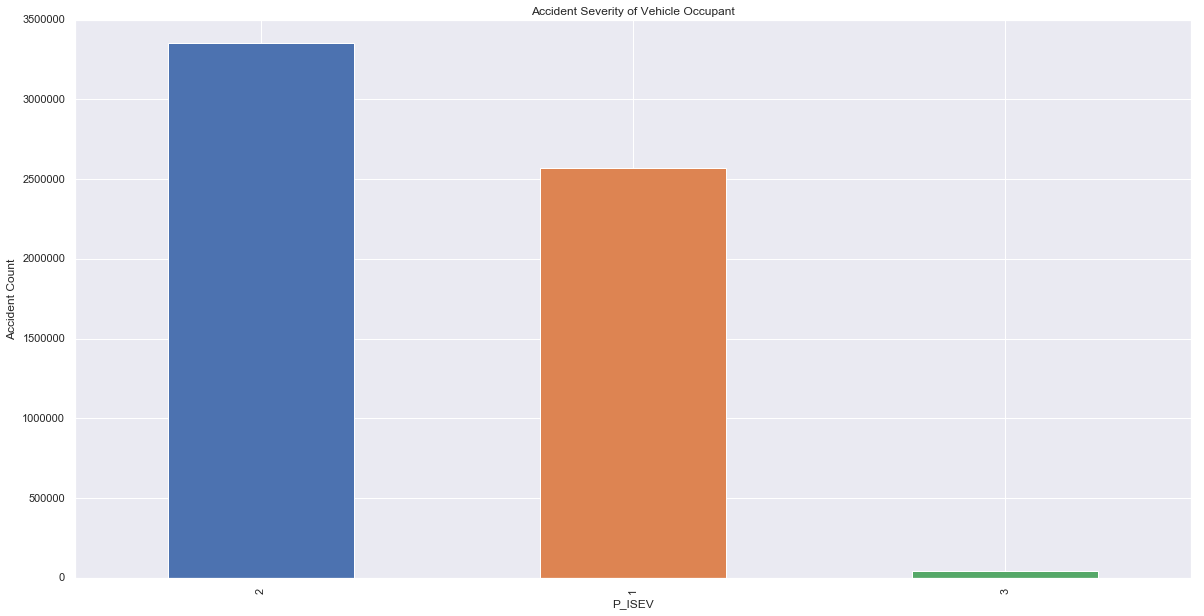

In [21]:
# Histogram of Accident Severity of Vehicle Occupant
plotSimpleHist(df['P_ISEV'], 'Accident Severity of Vehicle Occupant', hight=10, width=20)
severity_count(df['P_ISEV']).transpose()
#severity_count(df['P_ISEV'])

,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Severity,,,,,,,,,,,,,,,,,,
non-fatal,168424,168205,162682,166951,160045,153188,151574,147875,143625,132486,129787,132907,129365,128109,127482,119553,124929,120910
injury,215168,219716,213415,219364,212446,202761,201082,196739,189678,173911,168369,169878,165896,164925,162757,154497,159295,161719
fatal,2948,2876,2719,2895,2745,2700,2864,2844,2706,2393,2178,2204,1988,2037,1917,1817,1871,1857


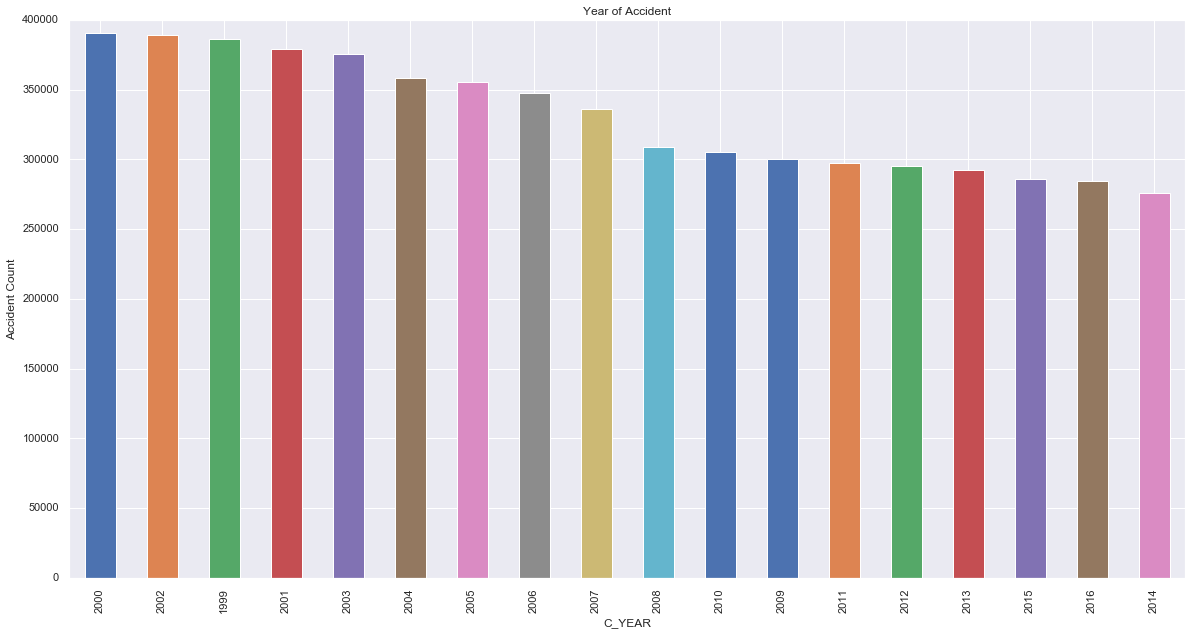

In [22]:
#Year of Accident
plotSimpleHist(df['C_YEAR'], 'Year of Accident', hight=10, width=20)
by_severity_count(df, 'C_YEAR', 'P_ISEV')

,01,02,03,04,05,06,07,08,09,10,11,12,UU
Severity,,,,,,,,,,,,,
non-fatal,218559.0,187964.0,182724.0,172957.0,205879.0,226421.0,235015.0,238598.0,225965.0,227541.0,216195.0,230235.0,44.0
injury,286089.0,242832.0,237226.0,224606.0,267509.0,298079.0,308825.0,311977.0,291028.0,293945.0,289024.0,300418.0,58.0
fatal,3096.0,2603.0,2704.0,2888.0,3554.0,3915.0,4527.0,4590.0,4123.0,4083.0,3759.0,3717.0,0.0


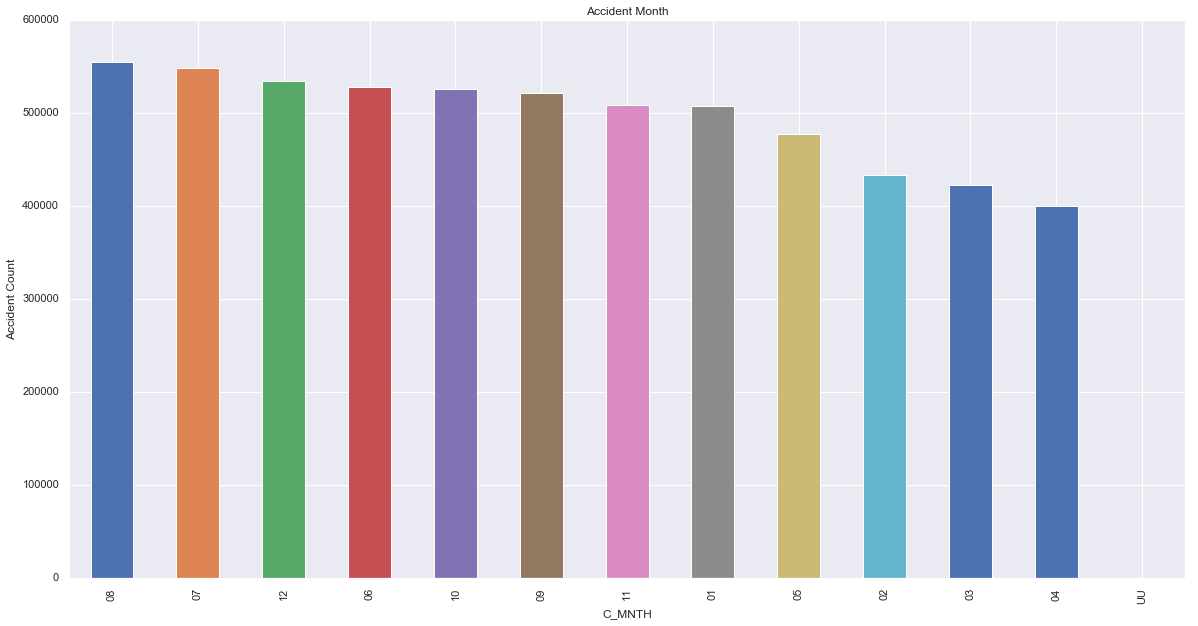

In [23]:
# Accident Month
plotSimpleHist(df['C_MNTH'], 'Accident Month', hight=10, width=20)
by_severity_count(df, 'C_MNTH', 'P_ISEV')

,1,2,3,4,5,6,7,U
Severity,,,,,,,,
non-fatal,338007,359710,363090,381356,442921,380978,301688,347
injury,448896,467675,471012,496320,563804,492588,410800,521
fatal,5382,5195,5383,6011,7079,7702,6802,5


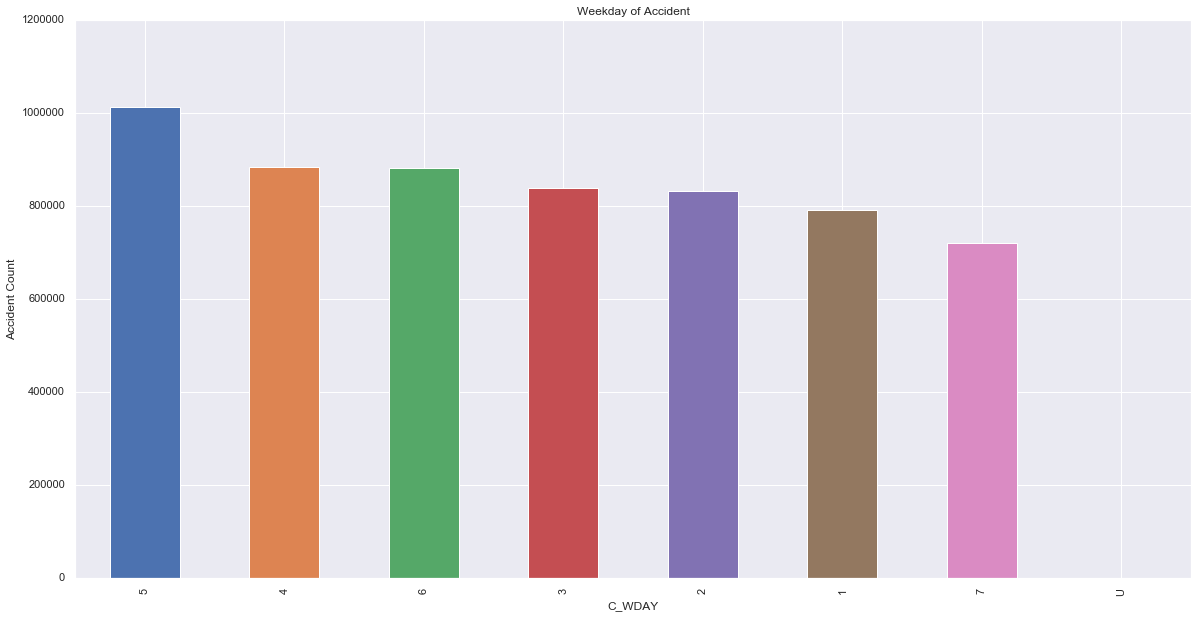

In [24]:
# Weekday of Accident
plotSimpleHist(df['C_WDAY'], 'Weekday of Accident', hight=10, width=20)
by_severity_count(df, 'C_WDAY', 'P_ISEV')

,00,01,02,03,04,05,06,07,08,09,...,15,16,17,18,19,20,21,22,23,UU
Severity,,,,,,,,,,,,,,,,,,,,,
non-fatal,30855,23469,24618,18055,10476,13166,39553,85478,135442,98776,...,232071,241742,234551,175028,125835,93138,84723,65565,47778,20689
injury,56251,47872,49762,42643,28201,32664,70012,127183,173760,134145,...,267408,284362,273193,208140,159060,125870,119934,98872,78584,33261
fatal,1393,1467,1531,1320,907,959,1328,1527,1472,1561,...,2537,2619,2564,2451,2157,2068,1945,1878,1642,573


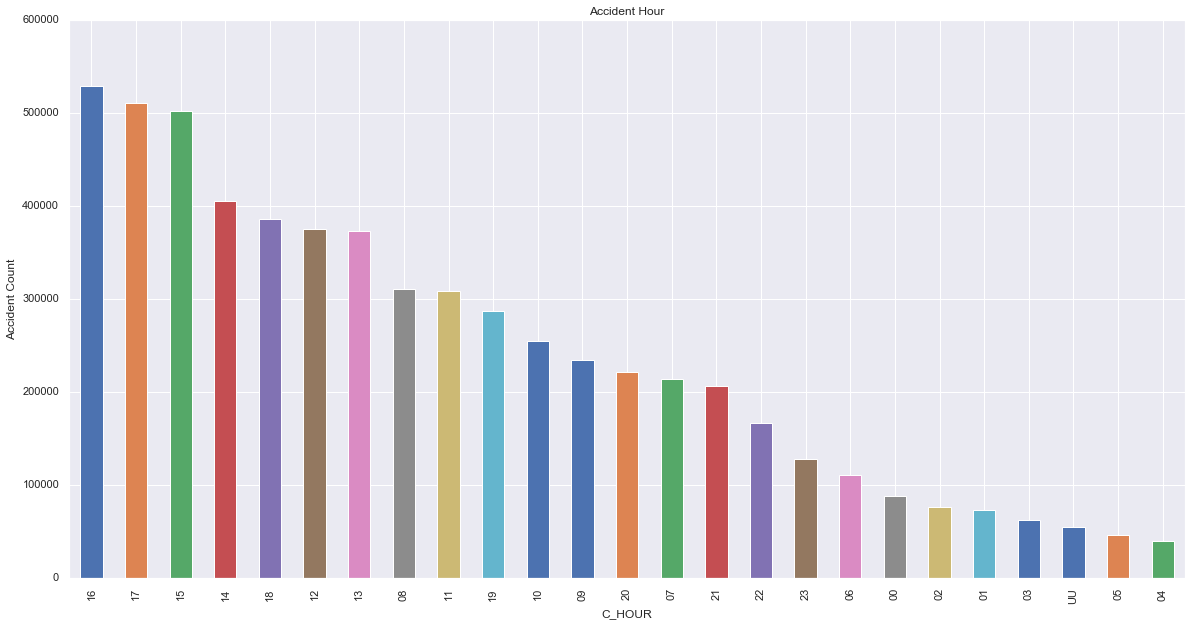

In [25]:
# Accident Hour
plotSimpleHist(df['C_HOUR'], 'Accident Hour', hight=10, width=20)
by_severity_count(df, 'C_HOUR', 'P_ISEV')

,01,02,03,04,05,06,07,08,09,10,...,47,51,54,56,57,58,71,72,77,UU
Severity,,,,,,,,,,,,,,,,,,,,,
non-fatal,323733.0,1678140.0,411716.0,108392.0,26664.0,8606.0,3263.0,1621.0,1090.0,747.0,...,0.0,40.0,64.0,40.0,50.0,10.0,31.0,109.0,111.0,100.0
injury,929489.0,1988583.0,333078.0,73371.0,16387.0,5131.0,1811.0,850.0,491.0,343.0,...,17.0,35.0,19.0,17.0,8.0,7.0,54.0,14.0,89.0,47.0
fatal,20515.0,19076.0,2872.0,698.0,197.0,82.0,41.0,13.0,5.0,4.0,...,0.0,0.0,1.0,1.0,0.0,0.0,7.0,0.0,1.0,1.0


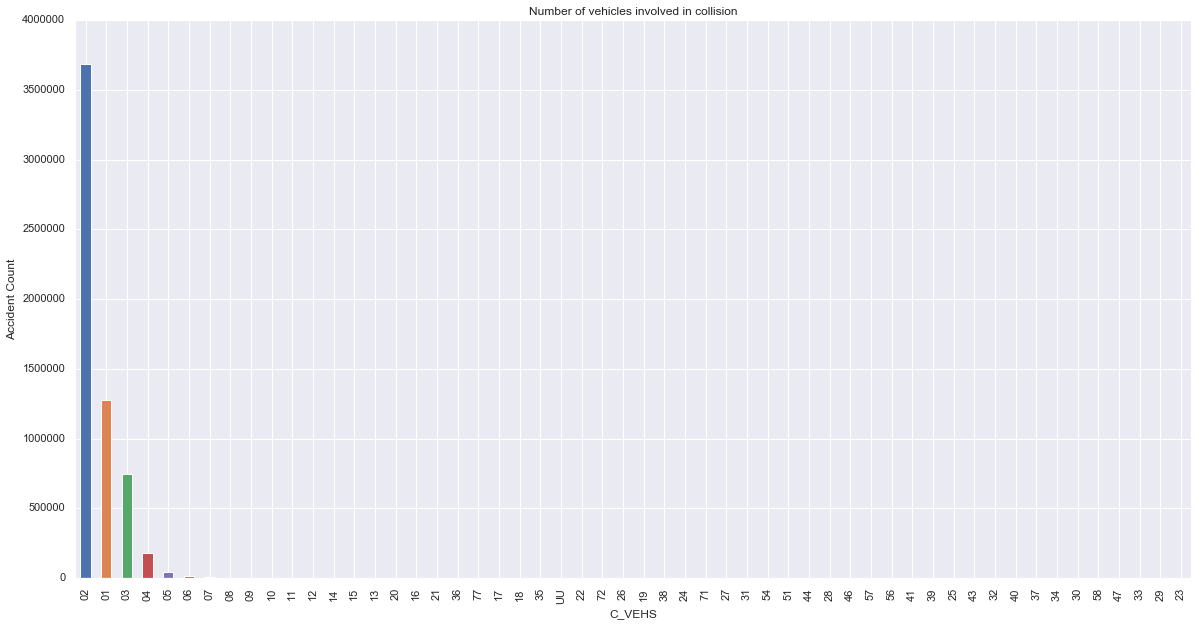

In [26]:
# Number of vehicles involved in collision
plotSimpleHist(df['C_VEHS'], 'Number of vehicles involved in collision', hight=10, width=20)
by_severity_count(df, 'C_VEHS', 'P_ISEV')

,01,02,03,04,05,06,21,22,23,24,25,31,32,33,34,35,36,41,QQ,UU
Severity,,,,,,,,,,,,,,,,,,,,
non-fatal,27959,38799,25046,30464,1309,194017,944535,111956,24693,20573,5786,65249,22120,187117,27901,391649,243300,25265,111862,68497
injury,54415,128690,143719,190530,12271,355598,862194,97133,35961,26343,6788,126402,26133,237723,32958,485809,242888,35999,156685,93377
fatal,1360,2658,3922,4664,195,6960,2017,861,345,164,43,8966,659,1574,268,4515,1016,443,2054,875


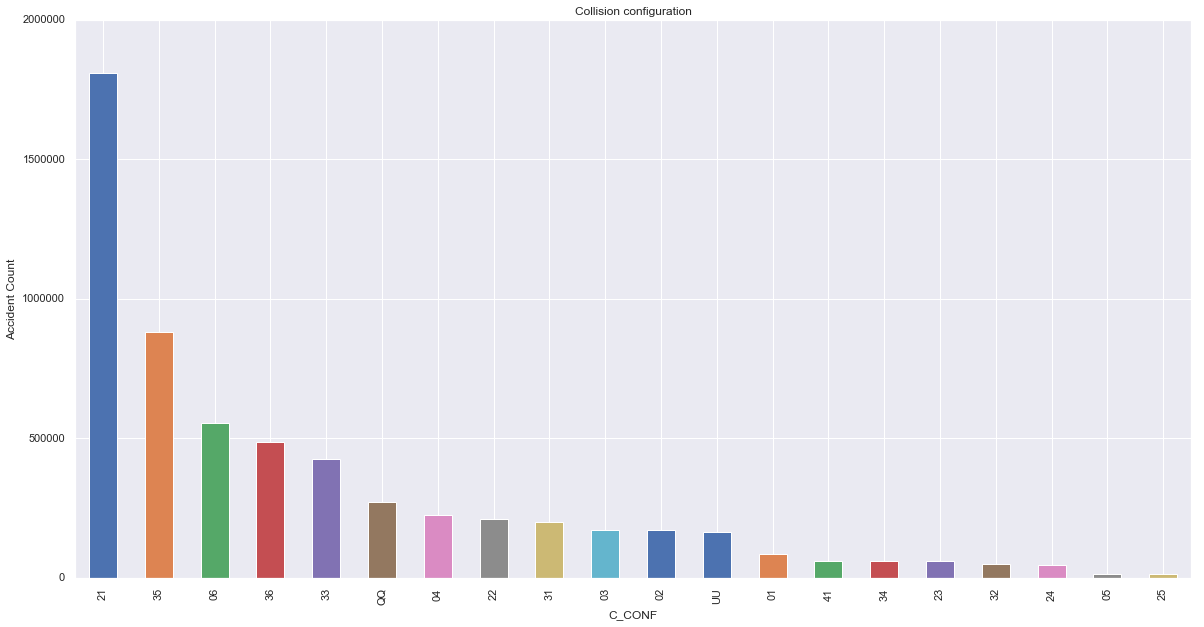

In [27]:
# Collision configuration
plotSimpleHist(df['C_CONF'], 'Collision configuration', hight=10, width=20)
by_severity_count(df, 'C_CONF', 'P_ISEV')

,01,02,03,04,05,06,07,08,09,10,QQ,UU
Severity,,,,,,,,,,,,
non-fatal,840984,1299410,151069,4539,21085,2123,253,5374,774,144,42322,200020
injury,1303027,1508278,152053,14051,29260,3685,611,7159,1141,250,84851,247250
fatal,26279,10823,1172,453,566,75,38,45,6,6,1419,2677


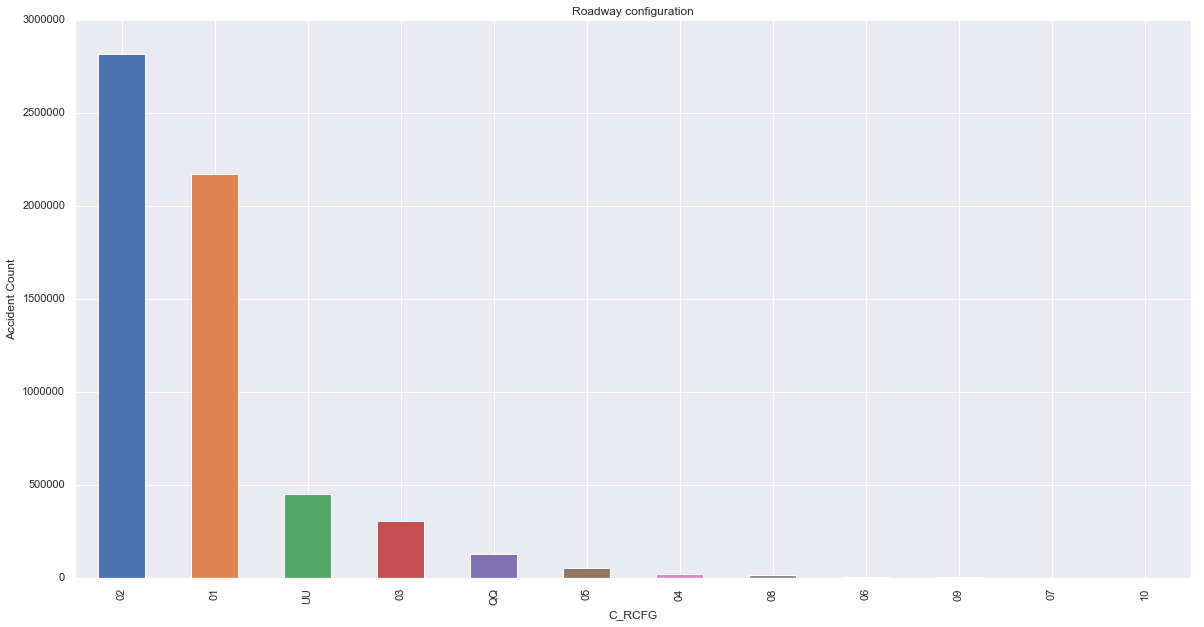

In [28]:
# Roadway configuration
plotSimpleHist(df['C_RCFG'], 'Roadway configuration', hight=10, width=20)
by_severity_count(df, 'C_RCFG', 'P_ISEV')

,1,2,3,4,5,6,7,Q,U
Severity,,,,,,,,,
non-fatal,1869581,212382,273196,144177,10795,28921,5367,6901,16777
injury,2319449,358552,337813,216649,19966,53397,10325,7638,27827
fatal,29359,5720,3629,2639,299,1231,248,116,318


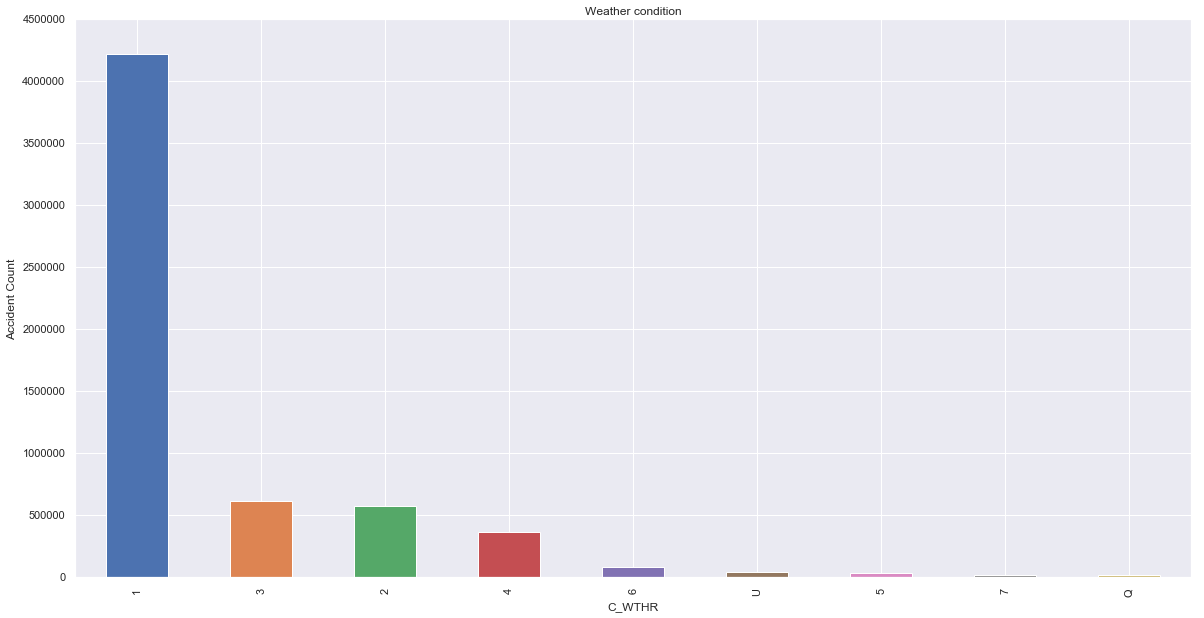

In [29]:
# Weather condition
plotSimpleHist(df['C_WTHR'], 'Weather condition', hight=10, width=20)
by_severity_count(df, 'C_WTHR', 'P_ISEV')

,1,2,3,4,5,6,7,8,9,Q,U
Severity,,,,,,,,,,,
non-fatal,1748000,486874,92121,29125,110153,5012,1506,316,80,78882,16028
injury,2188576,607841,160043,47371,207226,19851,4155,910,222,93788,21633
fatal,29520,6786,1851,620,2465,534,118,2,8,1385,270


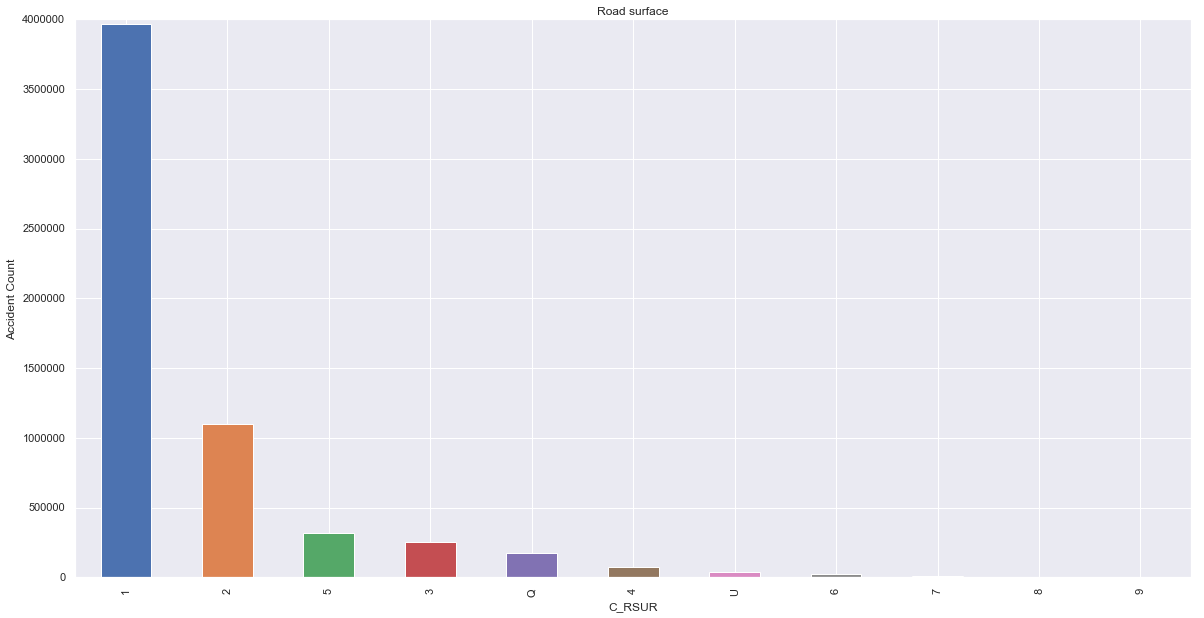

In [30]:
# Road surface
plotSimpleHist(df['C_RSUR'], 'Road surface', hight=10, width=20)
by_severity_count(df, 'C_RSUR', 'P_ISEV')

,1,2,3,4,5,6,Q,U
Severity,,,,,,,,
non-fatal,1905185,257676,110447,70955,13882,9252,4213,196487
injury,2351221,333729,255850,155488,25777,19353,12209,197989
fatal,24865,5210,6784,4325,557,448,101,1269


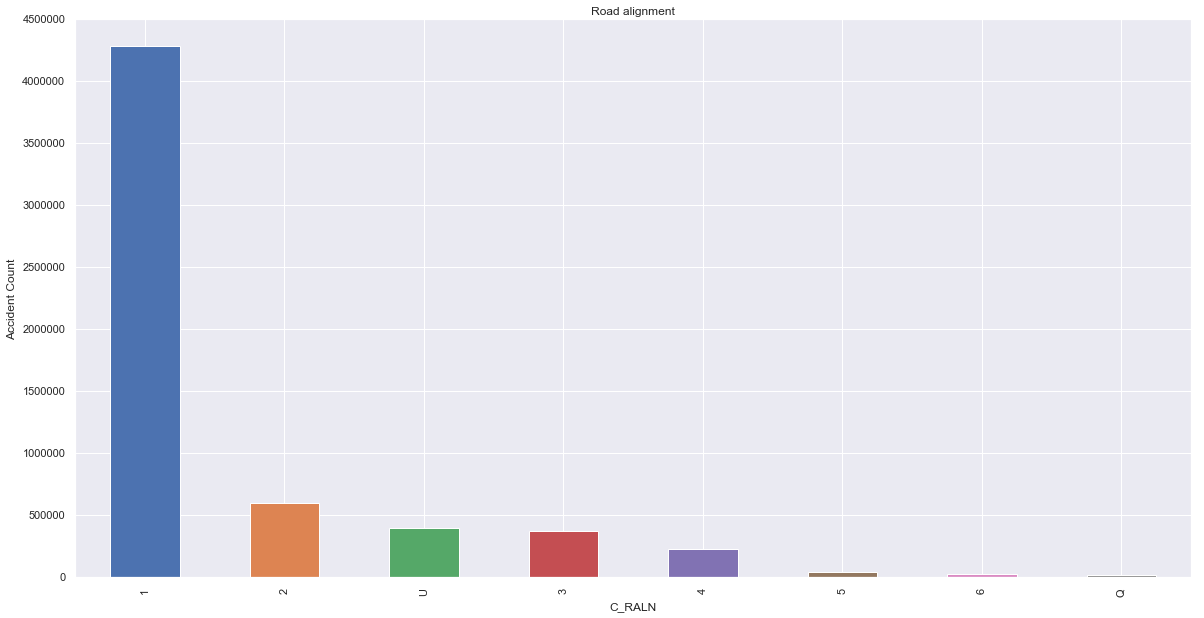

In [31]:
# Road alignment
plotSimpleHist(df['C_RALN'], 'Road alignment', hight=10, width=20)
by_severity_count(df, 'C_RALN', 'P_ISEV')

,01,02,03,04,05,06,07,08,09,10,11,12,13,15,16,17,18,QQ,UU
Severity,,,,,,,,,,,,,,,,,,,
non-fatal,829897,7956,306313,44242,887,23105,1201,12819,207,682,495,1063,2209,1238,221,1253,1233520,31384,69405
injury,869043,11075,368355,48385,2885,21994,1174,12718,310,1825,2282,1761,2083,2301,629,1831,1847720,39830,115415
fatal,3300,152,3501,221,82,161,10,69,1,65,73,59,11,107,51,32,33646,652,1366


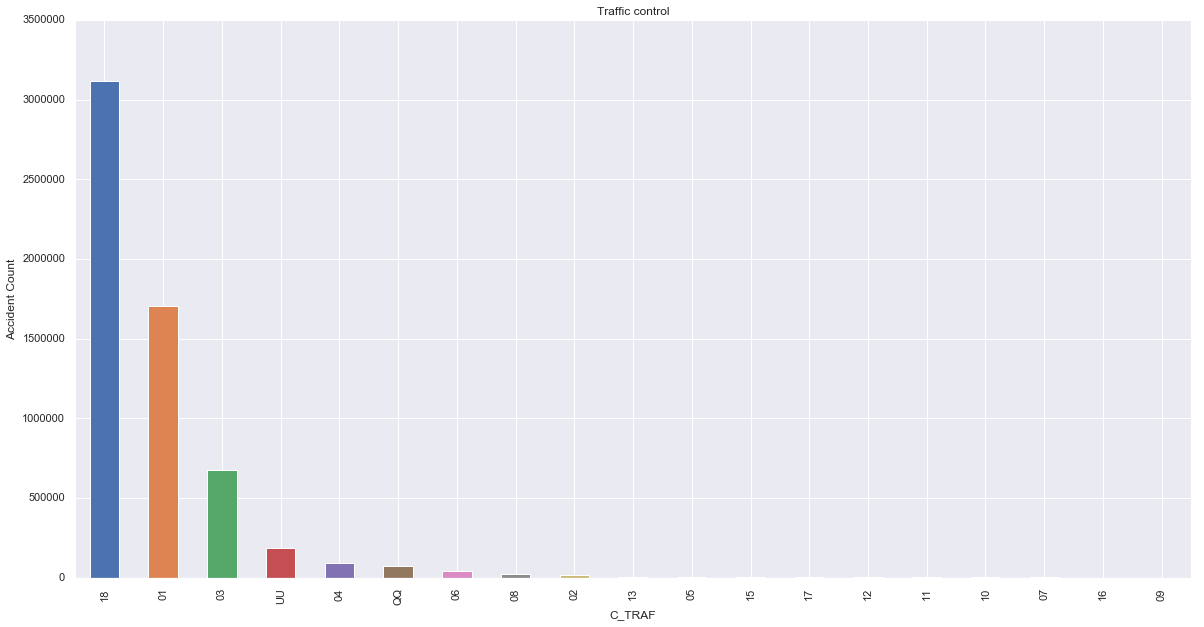

In [32]:
# Traffic control
plotSimpleHist(df['C_TRAF'], 'Traffic control', hight=10, width=20)
by_severity_count(df, 'C_TRAF', 'P_ISEV')

,01,02,03,04,05,06,07,08,09,10,...,71,72,73,74,75,76,77,86,99,UU
Severity,,,,,,,,,,,,,,,,,,,,,
non-fatal,1436966.0,877315.0,193394.0,40108.0,8776.0,2726.0,1151.0,632.0,453.0,263.0,...,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,4522.0,19.0
injury,1714280.0,1316105.0,98848.0,15408.0,3065.0,1000.0,475.0,258.0,194.0,104.0,...,1.0,5.0,2.0,0.0,0.0,2.0,1.0,1.0,201011.0,30.0
fatal,28363.0,8842.0,395.0,80.0,36.0,9.0,5.0,3.0,4.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5792.0,2.0


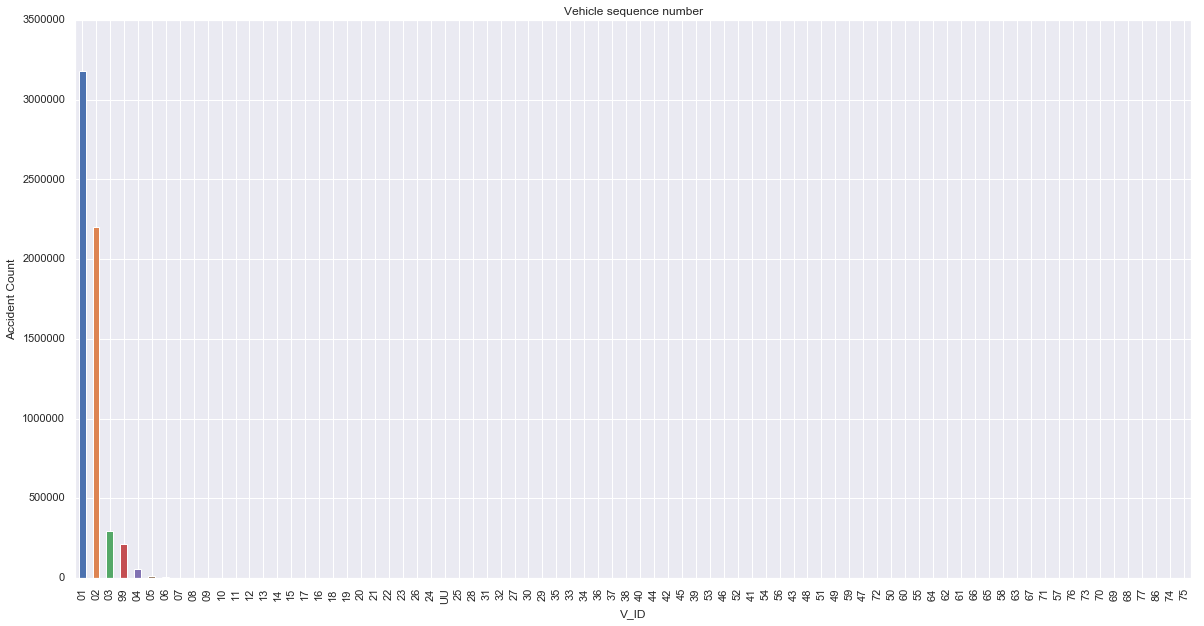

In [33]:
# Vehicle sequence number
# 99 = not a vehile
plotSimpleHist(df['V_ID'], 'Vehicle sequence number', hight=10, width=20)
by_severity_count(df, 'V_ID', 'P_ISEV')

,01,05,06,07,08,09,10,11,14,16,17,18,19,20,21,22,23,NN,QQ,UU
Severity,,,,,,,,,,,,,,,,,,,,
non-fatal,2239661.0,42135.0,89919.0,54394.0,42318.0,15500.0,628.0,30744.0,11057.0,1441.0,9063.0,1930.0,1349.0,3613.0,685.0,604.0,2453.0,5976.0,8938.0,5689.0
injury,2680170.0,28732.0,86325.0,29163.0,23243.0,6258.0,373.0,20190.0,119620.0,7645.0,122418.0,1262.0,613.0,1938.0,207.0,3236.0,884.0,202147.0,13659.0,3533.0
fatal,29238.0,315.0,1356.0,516.0,741.0,17.0,1.0,83.0,3478.0,441.0,991.0,34.0,44.0,106.0,2.0,240.0,0.0,5801.0,129.0,26.0


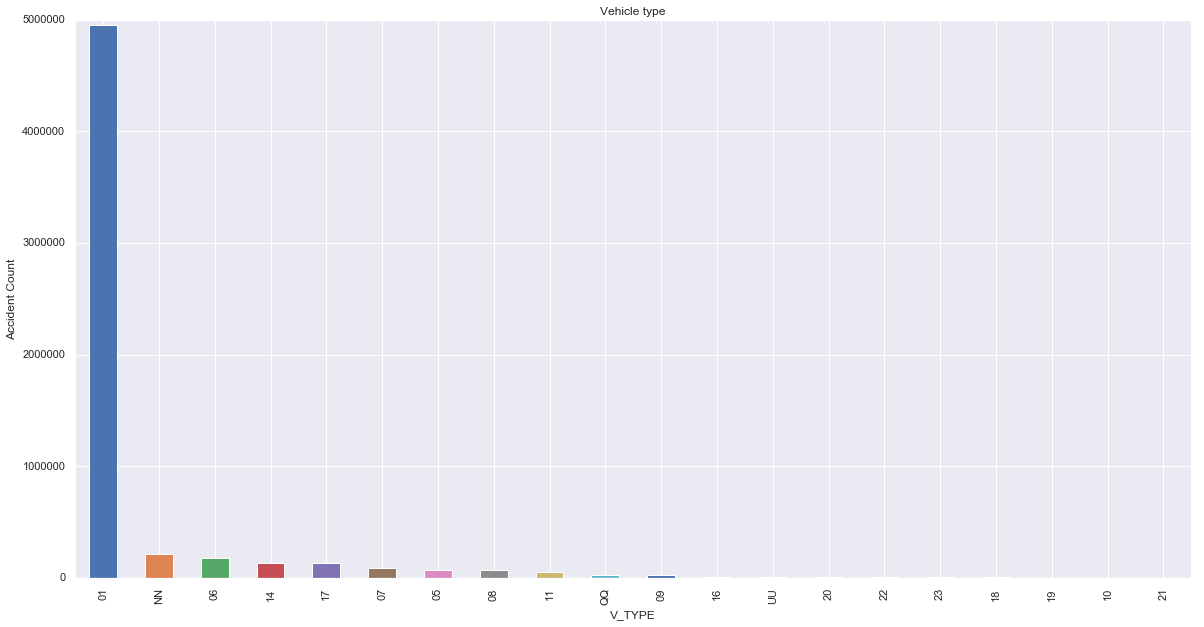

In [34]:
# Vehicle type
plotSimpleHist(df['V_TYPE'], 'Vehicle type', hight=10, width=20)
by_severity_count(df, 'V_TYPE', 'P_ISEV')

,1901,1903,1904,1905,1906,1907,1908,1909,1910,1911,...,2009,2010,2011,2012,2013,2014,2015,2016,NNNN,UUUU
Severity,,,,,,,,,,,,,,,,,,,,,
non-fatal,8.0,3.0,1.0,0.0,1.0,1.0,2.0,1.0,0.0,8.0,...,58316.0,56569.0,44029.0,38987.0,33243.0,24437.0,17010.0,7406.0,4832.0,111485.0
injury,6.0,5.0,1.0,3.0,0.0,1.0,2.0,0.0,1.0,2.0,...,68804.0,61698.0,44604.0,41274.0,35883.0,26331.0,17284.0,7386.0,242279.0,160160.0
fatal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,585.0,484.0,326.0,330.0,244.0,204.0,135.0,50.0,6120.0,2381.0


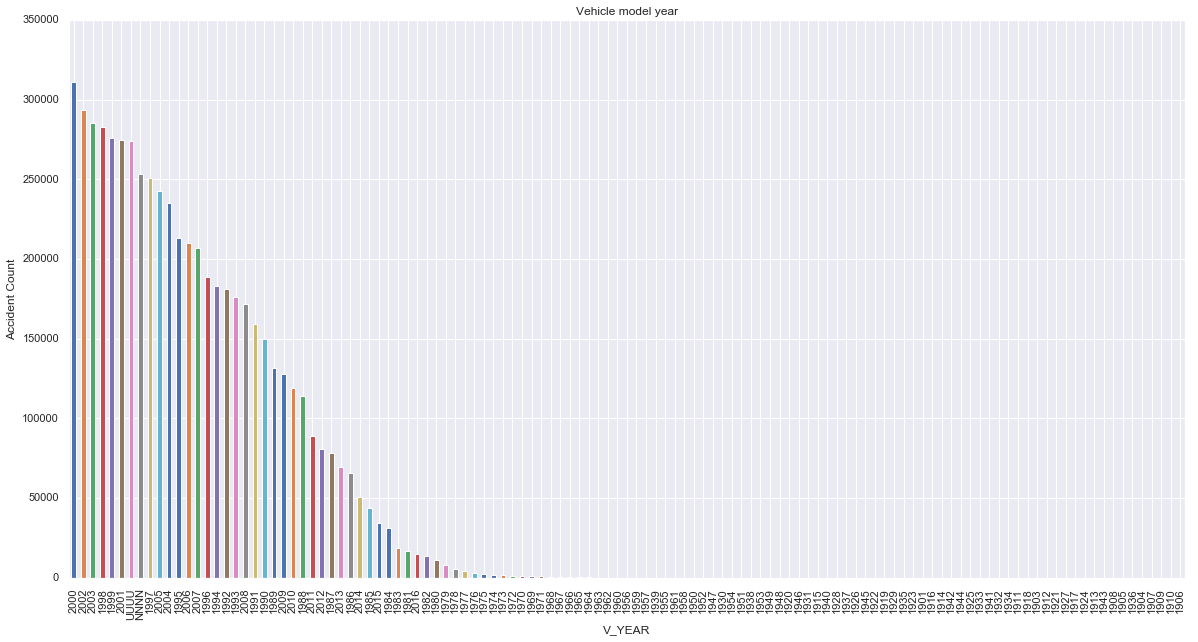

In [35]:
# Vehicle model year
plotSimpleHist(df['V_YEAR'], 'Vehicle model year', hight=10, width=20)
by_severity_count(df, 'V_YEAR', 'P_ISEV')

,01,02,03,04,05,06,07,08,09,10,...,87,88,89,90,91,92,93,99,NN,UU
Severity,,,,,,,,,,,,,,,,,,,,,
non-fatal,1778649.0,476140.0,190152.0,78686.0,24826.0,7145.0,3032.0,1434.0,949.0,748.0,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,5.0
injury,2384501.0,713268.0,166270.0,58352.0,17887.0,4938.0,1943.0,876.0,508.0,396.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,14.0
fatal,33104.0,7144.0,2062.0,790.0,301.0,87.0,31.0,12.0,9.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


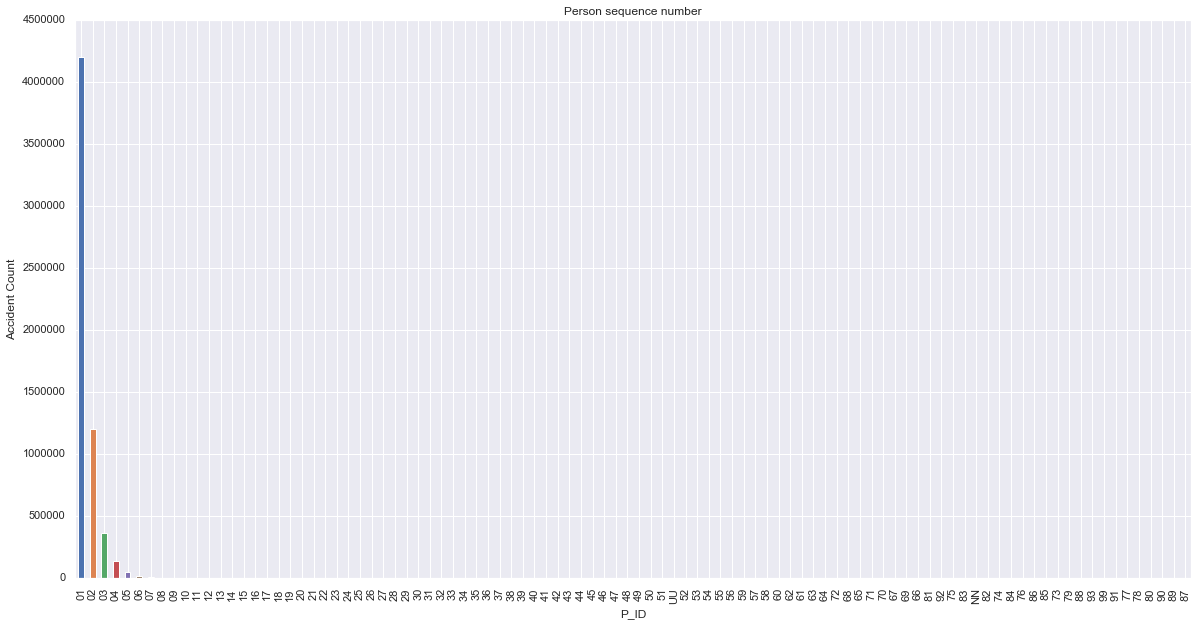

In [36]:
# Person sequence number
plotSimpleHist(df['P_ID'], 'Person sequence number', hight=10, width=20)
by_severity_count(df, 'P_ID', 'P_ISEV')

,F,M,N,U
Severity,,,,
non-fatal,907614.0,1608391.0,209.0,51883.0
injury,1690685.0,1626423.0,27.0,34481.0
fatal,13369.0,30149.0,0.0,41.0


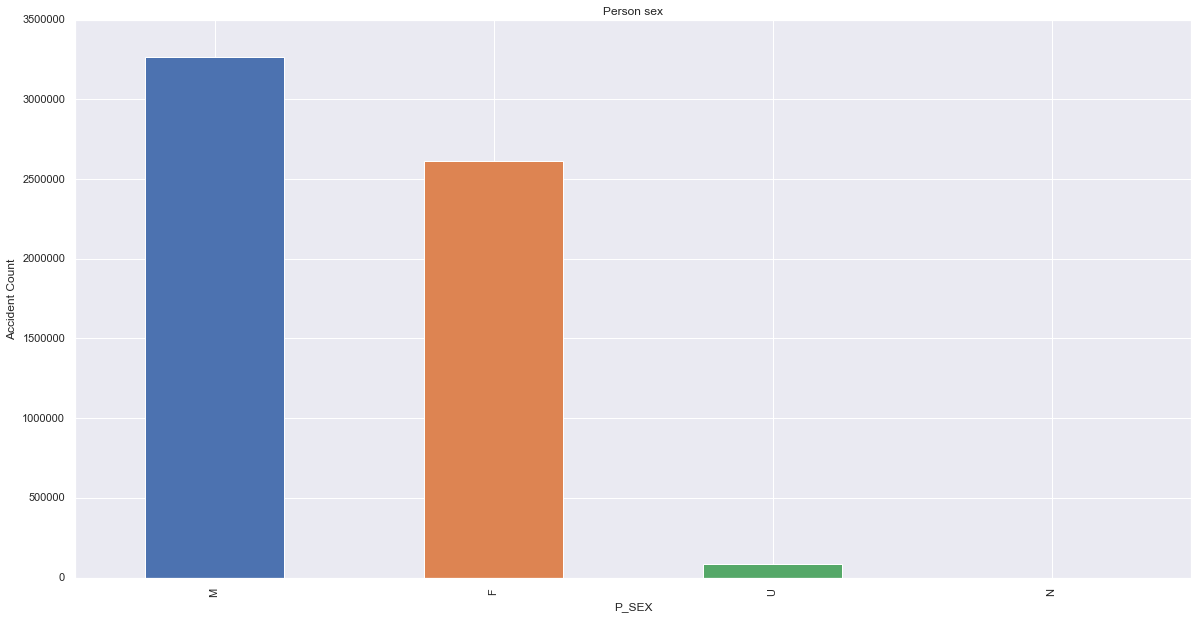

In [37]:
# Person sex
plotSimpleHist(df['P_SEX'], 'Person sex', hight=10, width=20)
by_severity_count(df, 'P_SEX', 'P_ISEV')

,01,02,03,04,05,06,07,08,09,10,...,92,93,94,95,96,97,98,99,NN,UU
Severity,,,,,,,,,,,,,,,,,,,,,
non-fatal,30821,19312,18478,18001,17208,15524,15194,14915,14483,14697,...,410,256,167,113,60,40,74,144,200,146748
injury,13175,8260,9303,10722,11668,12667,13768,14381,15052,16070,...,708,516,357,207,143,95,149,171,2423,98968
fatal,149,72,67,97,98,98,104,90,108,110,...,51,39,25,20,13,7,6,8,5,211


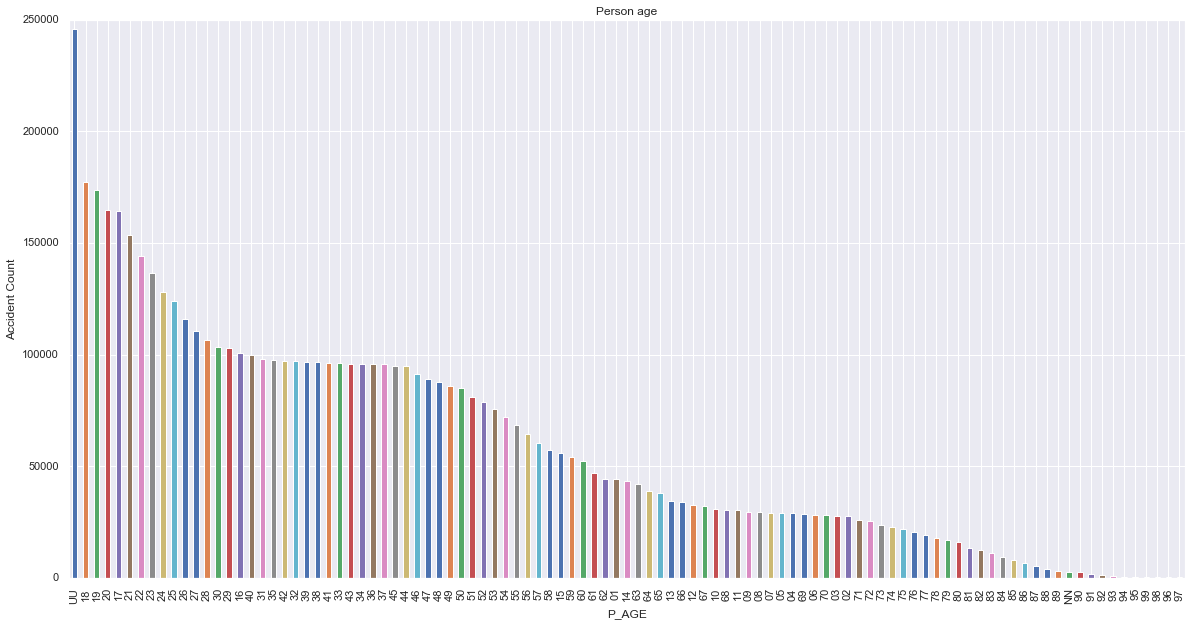

In [38]:
# Person age
plotSimpleHist(df['P_AGE'], 'Person age', hight=10, width=20)
by_severity_count(df, 'P_AGE', 'P_ISEV')

,11,12,13,21,22,23,31,32,33,96,97,98,99,NN,QQ,UU
Severity,,,,,,,,,,,,,,,,
non-fatal,1782609,33153,379561,123811,52415,149840,2931,17486,3574,11577,117,1072,4256,45,2122,3528
injury,2165018,59148,572621,110616,43469,130551,2098,14533,2815,34133,158,5514,200994,142,2932,6874
fatal,26626,592,5846,1337,489,1288,35,216,36,997,4,111,5792,3,53,134


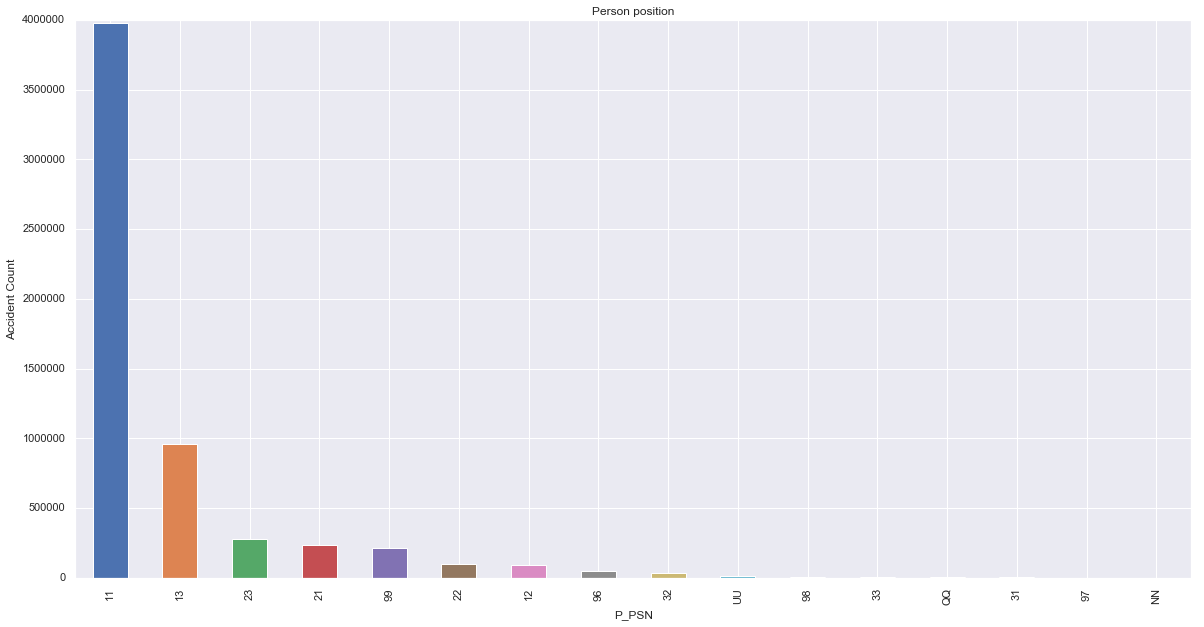

In [39]:
# Person position
plotSimpleHist(df['P_PSN'], 'Person position', hight=10, width=20)
by_severity_count(df, 'P_PSN', 'P_ISEV')

,01,02,09,10,11,12,13,NN,QQ,UU
Severity,,,,,,,,,,
non-fatal,32656,2007645,3621,8,3,5001,32197,171569,11327,304070
injury,165288,2548978,105590,143,9,20746,120726,141379,39976,208781
fatal,11044,18070,2938,11,1,348,2278,3378,715,4776


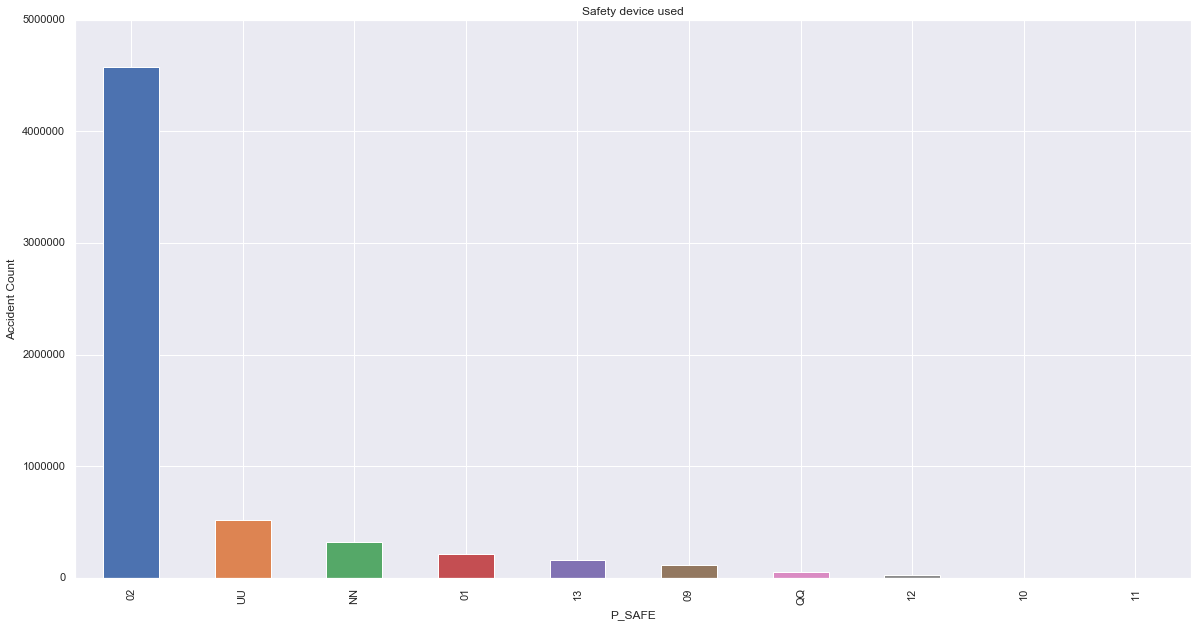

In [40]:
# Safety device used
plotSimpleHist(df['P_SAFE'], 'Safety device used', hight=10, width=20)
by_severity_count(df, 'P_SAFE', 'P_ISEV')

,1,2,3,4,5,U
Severity,,,,,,
non-fatal,1748373,765779,4522,9063,11057,29303
injury,1945995,918288,201011,122418,119620,44284
fatal,22283,9764,5792,991,3478,1251


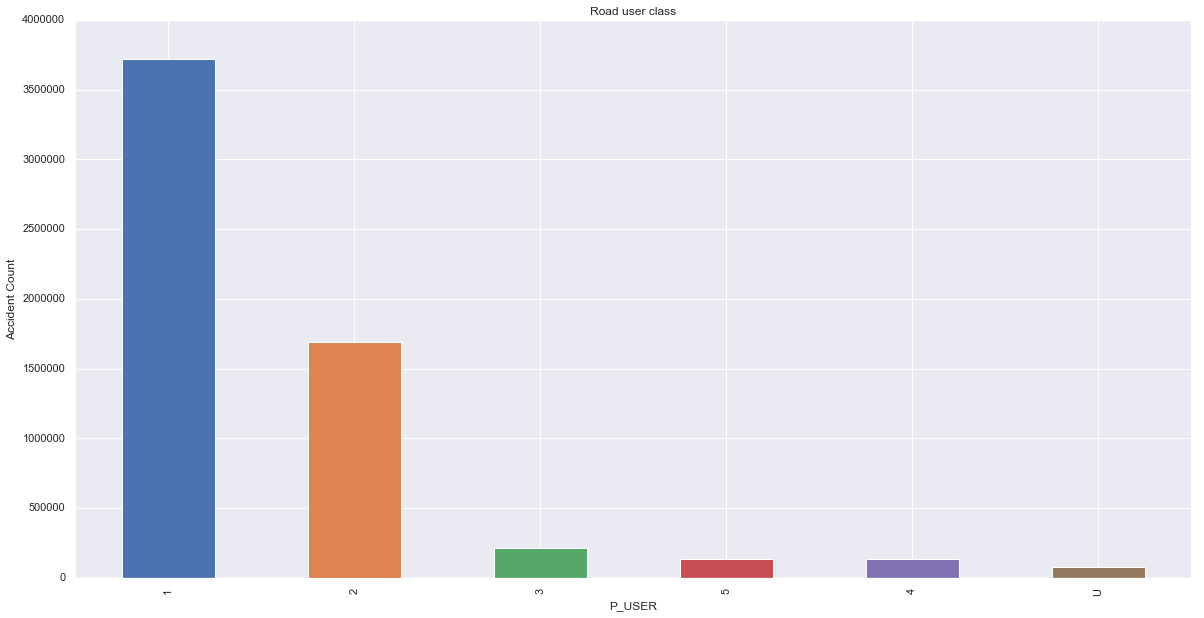

In [41]:
# Road user class
plotSimpleHist(df['P_USER'], 'Road user class', hight=10, width=20)
by_severity_count(df, 'P_USER', 'P_ISEV')

### Copy dataset

In [42]:
dfcopy2 = df.copy()

## Clean dataset

#### Clean: P_ISEV

Severity,injury,non-fatal,fatal
Count,3351616,2568097,43559


Dropped 265119 rows from dataset


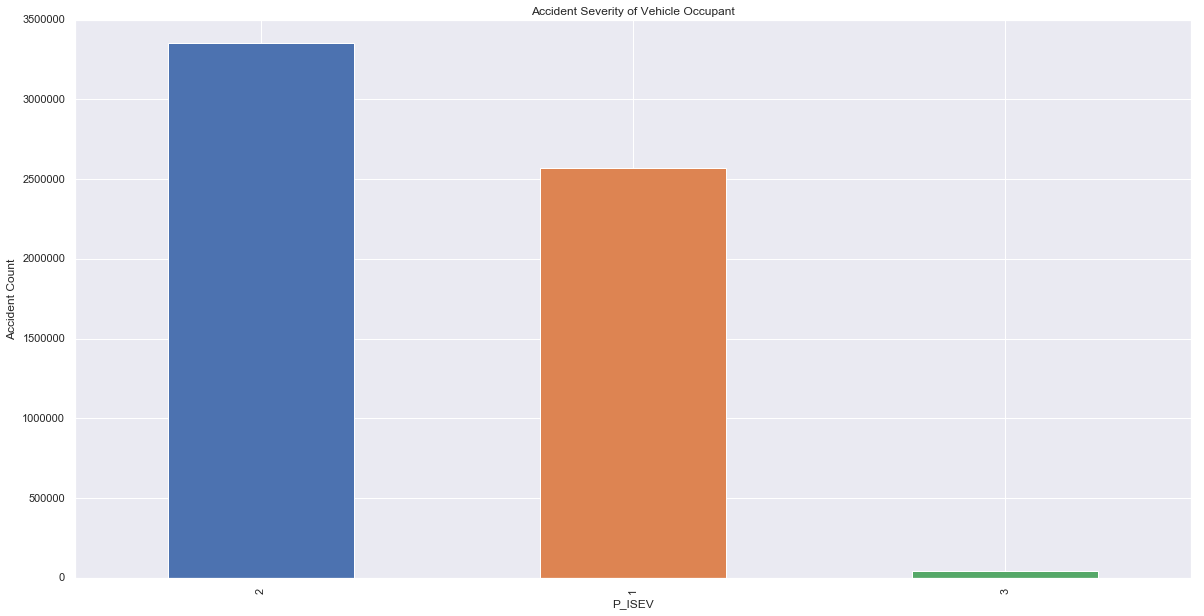

In [43]:
#P_ISEV
#df = dfcopy2.copy()
display(severity_count(df['P_ISEV']).transpose())
plotSimpleHist(df['P_ISEV'], 'Accident Severity of Vehicle Occupant', hight=10, width=20)
print("Dropped {drop_count} rows from dataset".format(drop_count = drop_count))

#### Clean: C_YEAR

,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Severity,,,,,,,,,,,,,,,,,,
non-fatal,168424,168205,162682,166951,160045,153188,151574,147875,143625,132486,129787,132907,129365,128109,127482,119553,124929,120910
injury,215168,219716,213415,219364,212446,202761,201082,196739,189678,173911,168369,169878,165896,164925,162757,154497,159295,161719
fatal,2948,2876,2719,2895,2745,2700,2864,2844,2706,2393,2178,2204,1988,2037,1917,1817,1871,1857


0 non-numeric rows observed


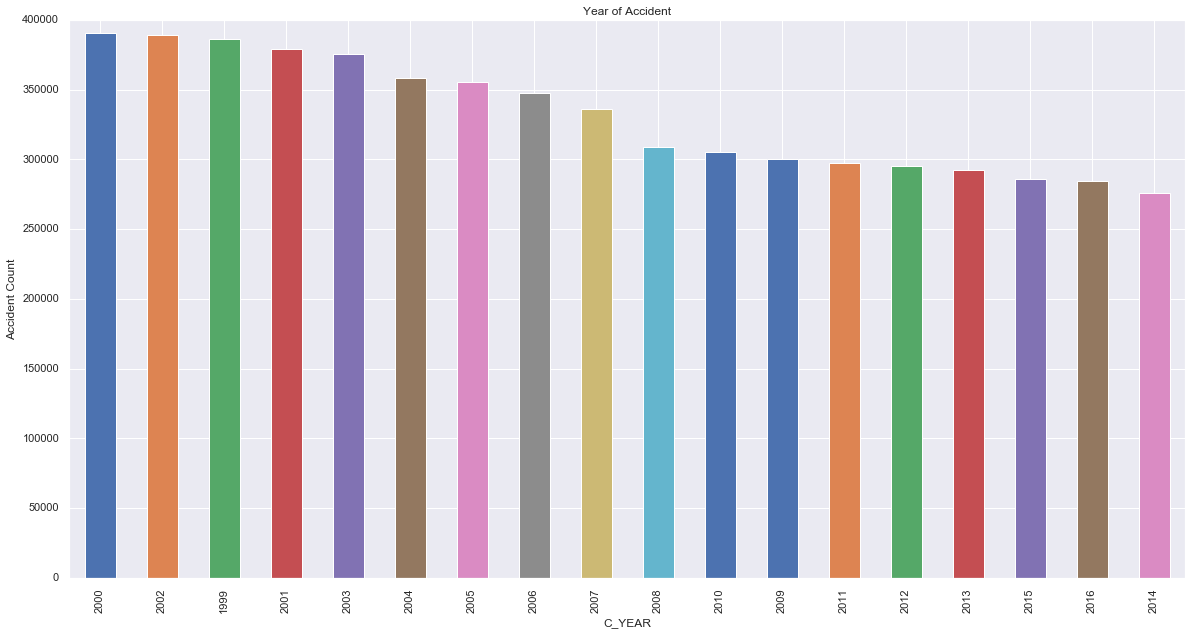

In [44]:
#C_YEAR
display(by_severity_count(df, 'C_YEAR', 'P_ISEV'))
plotSimpleHist(df['C_YEAR'], 'Year of Accident', hight=10, width=20)
print("{count} non-numeric rows observed".format(count = df['C_YEAR'].astype('str').str.contains('[^0-9]').sum()))

#### Clean: C_MNTH

,01,02,03,04,05,06,07,08,09,10,11,12,UU
Severity,,,,,,,,,,,,,
non-fatal,218559.0,187964.0,182724.0,172957.0,205879.0,226421.0,235015.0,238598.0,225965.0,227541.0,216195.0,230235.0,44.0
injury,286089.0,242832.0,237226.0,224606.0,267509.0,298079.0,308825.0,311977.0,291028.0,293945.0,289024.0,300418.0,58.0
fatal,3096.0,2603.0,2704.0,2888.0,3554.0,3915.0,4527.0,4590.0,4123.0,4083.0,3759.0,3717.0,0.0


59577 non-numeric rows observed


C:\Users\pradeep\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


0 non-numeric rows observed


,01,02,03,04,05,06,07,08,09,10,11,12
Severity,,,,,,,,,,,,
non-fatal,218564,187966,182729,172962,205882,226425,235016,238602,225969,227545,216195,230242
injury,286091,242835,237231,224614,267515,298085,308829,311983,291030,293952,289029,300422
fatal,3096,2603,2704,2888,3554,3915,4527,4590,4123,4083,3759,3717


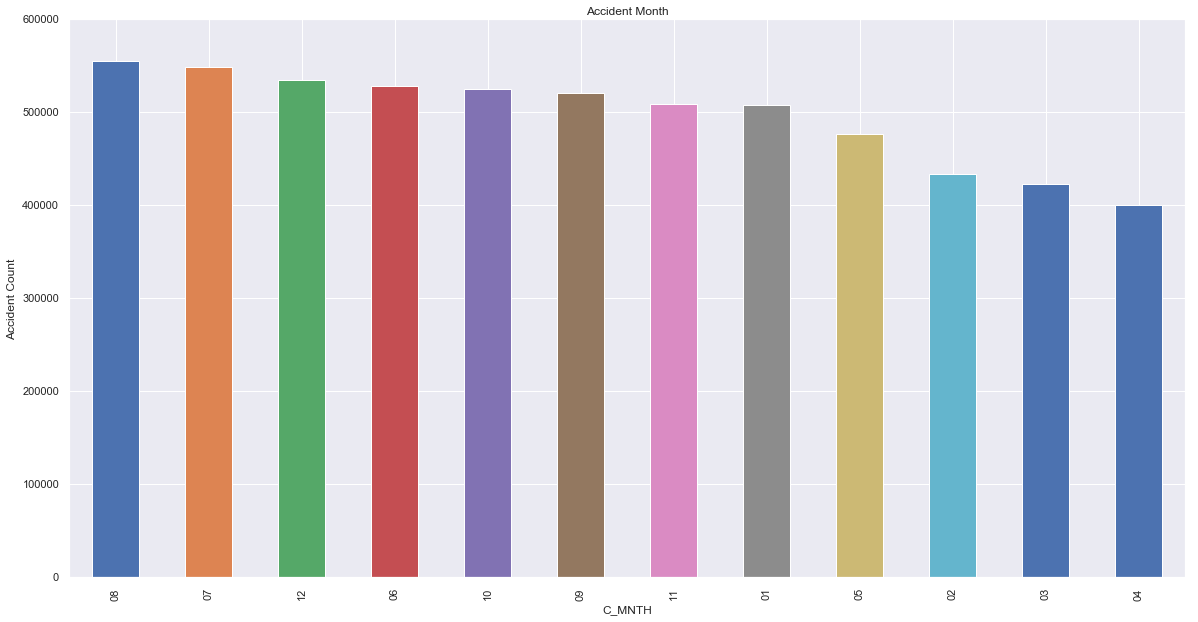

In [45]:
display(by_severity_count(df, 'C_MNTH', 'P_ISEV'))
print("{count} non-numeric rows observed".format(count = df['C_WTHR'].astype('str').str.contains('[^0-9]').sum()))
gbC_MNTH = checkHistogram(df, 'C_MNTH', 'P_ISEV', False)
P = computeP(gbC_MNTH)
#data_to_impute = df['C_MNTH'].astype('str').str.contains('UU')
#df[data_to_impute] = df.loc[data_to_impute].apply(lambda x: x.replace('UU', selectBin(1, 13, P, True)))

data_to_impute = df['C_MNTH'].astype('str').str.contains('UU')
df['C_MNTH'][data_to_impute] = df['C_MNTH'][data_to_impute].apply(lambda x: x.replace('UU', selectBin(1, 13, P, True)))

print("{count} non-numeric rows observed".format(count = df['C_MNTH'].astype('str').str.contains('[^0-9]').sum()))
plotSimpleHist(df['C_MNTH'], 'Accident Month', hight=10, width=20)
display(by_severity_count(df, 'C_MNTH', 'P_ISEV'))

#### Clean: C_WDAY

,1,2,3,4,5,6,7,U
Severity,,,,,,,,
non-fatal,338007,359710,363090,381356,442921,380978,301688,347
injury,448896,467675,471012,496320,563804,492588,410800,521
fatal,5382,5195,5383,6011,7079,7702,6802,5


873 non-numeric rows observed


C:\Users\pradeep\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


0 non-numeric rows observed


,1,2,3,4,5,6,7
Severity,,,,,,,
non-fatal,338037,359764,363144,381414,442989,381015,301734
injury,448962,467743,471093,496394,563889,492670,410865
fatal,5382,5197,5384,6013,7079,7702,6802


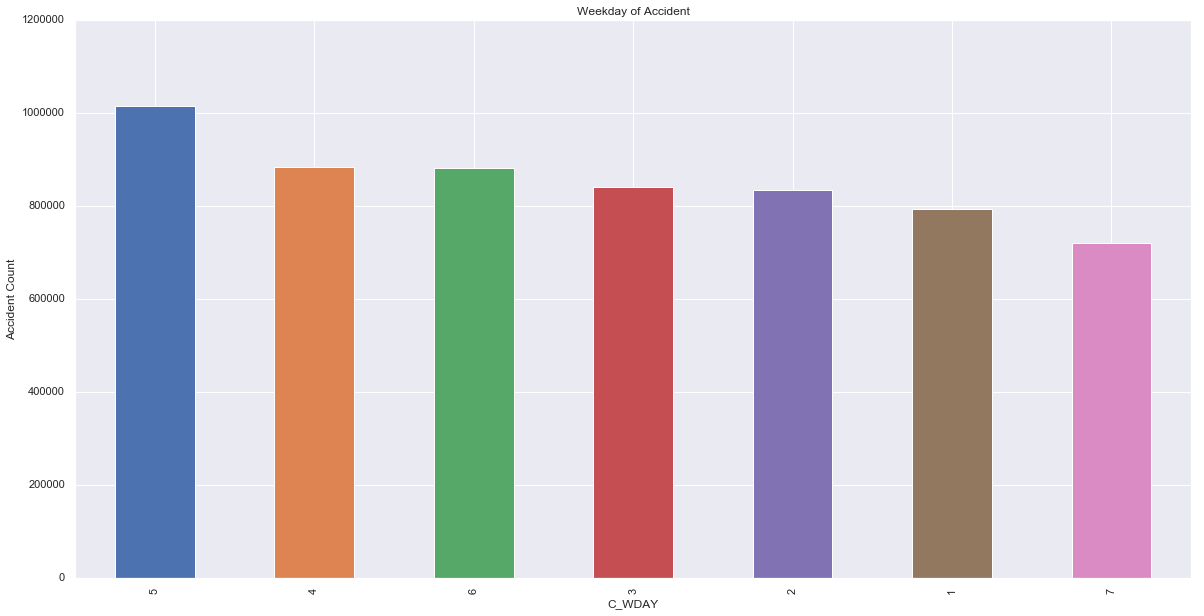

In [46]:
# C_WDAY
display(by_severity_count(df, 'C_WDAY', 'P_ISEV')) 
cleanData(df, 'C_WDAY', 'P_ISEV', ['U'], 1, 8, False)
plotSimpleHist(df['C_WDAY'], 'Weekday of Accident', hight=10, width=20)
display(by_severity_count(df, 'C_WDAY', 'P_ISEV'))

#### Clean: C_HOUR

,00,01,02,03,04,05,06,07,08,09,...,15,16,17,18,19,20,21,22,23,UU
Severity,,,,,,,,,,,,,,,,,,,,,
non-fatal,30855,23469,24618,18055,10476,13166,39553,85478,135442,98776,...,232071,241742,234551,175028,125835,93138,84723,65565,47778,20689
injury,56251,47872,49762,42643,28201,32664,70012,127183,173760,134145,...,267408,284362,273193,208140,159060,125870,119934,98872,78584,33261
fatal,1393,1467,1531,1320,907,959,1328,1527,1472,1561,...,2537,2619,2564,2451,2157,2068,1945,1878,1642,573


54523 non-numeric rows observed


C:\Users\pradeep\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


0 non-numeric rows observed


,00,01,02,03,04,05,06,07,08,09,...,15,16,17,18,19,20,21,22,23,24
Severity,,,,,,,,,,,,,,,,,,,,,
non-fatal,30855,23782,24858,18334,10711,13301,39716,85895,136141,99898,...,233457,243519,236396,176802,127214,94104,85529,66251,48335,429
injury,56251,48397,50160,43076,28523,32874,70250,127802,175007,135828,...,269770,287254,276170,211043,161210,127493,121187,100015,79497,686
fatal,1393,1474,1539,1333,913,961,1335,1534,1486,1587,...,2580,2677,2615,2502,2199,2088,1962,1904,1658,12


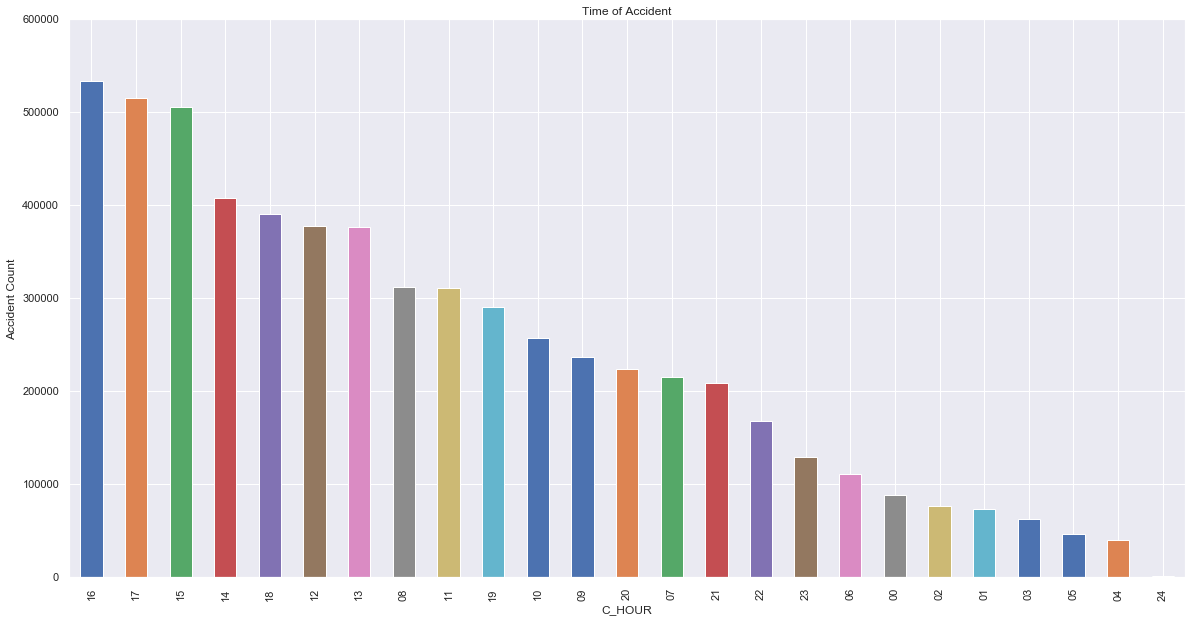

In [47]:
#C_HOUR
display(by_severity_count(df, 'C_HOUR', 'P_ISEV')) 
cleanData(df, 'C_HOUR', 'P_ISEV', ['UU'], 1, 25, True)
plotSimpleHist(df['C_HOUR'], 'Time of Accident', hight=10, width=20)
display(by_severity_count(df, 'C_HOUR', 'P_ISEV'))

#### Clean: C_VEHS

,01,02,03,04,05,06,07,08,09,10,...,47,51,54,56,57,58,71,72,77,UU
Severity,,,,,,,,,,,,,,,,,,,,,
non-fatal,323733.0,1678140.0,411716.0,108392.0,26664.0,8606.0,3263.0,1621.0,1090.0,747.0,...,0.0,40.0,64.0,40.0,50.0,10.0,31.0,109.0,111.0,100.0
injury,929489.0,1988583.0,333078.0,73371.0,16387.0,5131.0,1811.0,850.0,491.0,343.0,...,17.0,35.0,19.0,17.0,8.0,7.0,54.0,14.0,89.0,47.0
fatal,20515.0,19076.0,2872.0,698.0,197.0,82.0,41.0,13.0,5.0,4.0,...,0.0,0.0,1.0,1.0,0.0,0.0,7.0,0.0,1.0,1.0


148 non-numeric rows observed


C:\Users\pradeep\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


0 non-numeric rows observed


,01,02,03,04,05,06,07,08,09,10,...,46,47,51,54,56,57,58,71,72,77
Severity,,,,,,,,,,,,,,,,,,,,,
non-fatal,323755.0,1678204.0,411729.0,108393.0,26664.0,8606.0,3263.0,1621.0,1090.0,747.0,...,45.0,0.0,40.0,64.0,40.0,50.0,10.0,31.0,109.0,111.0
injury,929501.0,1988614.0,333081.0,73372.0,16387.0,5131.0,1811.0,850.0,491.0,343.0,...,14.0,17.0,35.0,19.0,17.0,8.0,7.0,54.0,14.0,89.0
fatal,20515.0,19077.0,2872.0,698.0,197.0,82.0,41.0,13.0,5.0,4.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,7.0,0.0,1.0


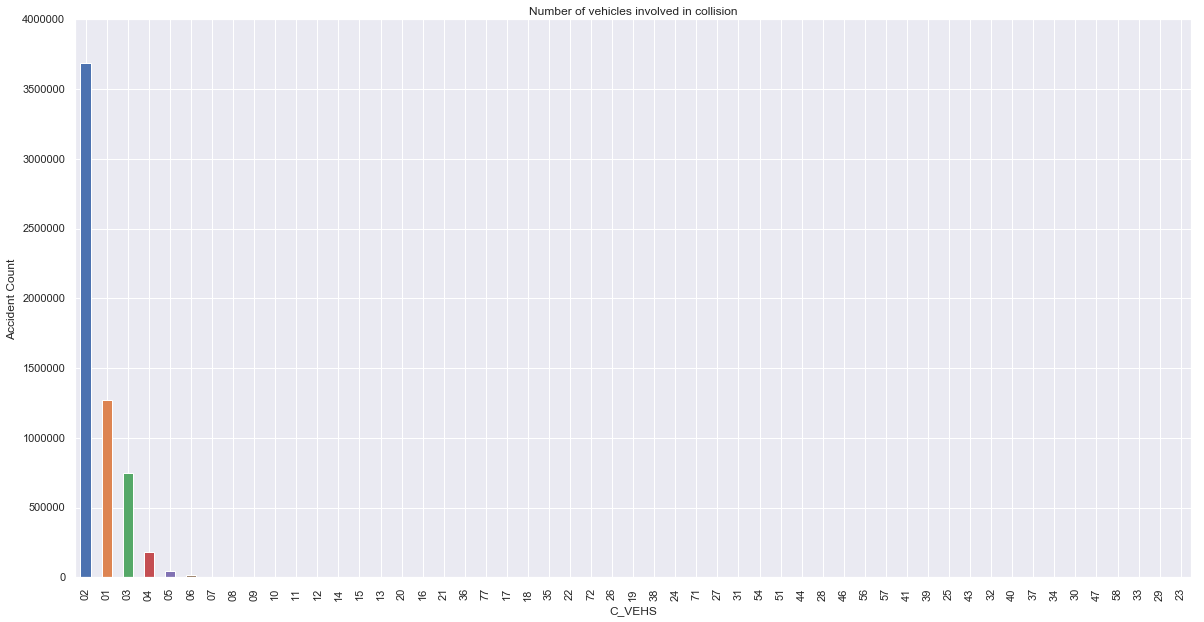

In [48]:
# C_VEHS
display(by_severity_count(df, 'C_VEHS', 'P_ISEV')) 
cleanData(df, 'C_VEHS', 'P_ISEV', ['UU'], 1, 78, True)
plotSimpleHist(df['C_VEHS'], 'Number of vehicles involved in collision', hight=10, width=20)
display(by_severity_count(df, 'C_VEHS', 'P_ISEV'))

#### Clean: C_CONF

,01,02,03,04,05,06,21,22,23,24,25,31,32,33,34,35,36,41,QQ,UU
Severity,,,,,,,,,,,,,,,,,,,,
non-fatal,27959,38799,25046,30464,1309,194017,944535,111956,24693,20573,5786,65249,22120,187117,27901,391649,243300,25265,111862,68497
injury,54415,128690,143719,190530,12271,355598,862194,97133,35961,26343,6788,126402,26133,237723,32958,485809,242888,35999,156685,93377
fatal,1360,2658,3922,4664,195,6960,2017,861,345,164,43,8966,659,1574,268,4515,1016,443,2054,875


433350 non-numeric rows observed


C:\Users\pradeep\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


0 non-numeric rows observed


,01,02,03,04,05,06,21,22,23,24,25,31,32,33,34,35,36,41
Severity,,,,,,,,,,,,,,,,,,
non-fatal,30626,44406,30767,37775,1745,212117,1003413,118998,26698,22123,6259,71678,23684,200907,29914,420447,259281,27259
injury,58225,136322,151470,200692,12929,380719,943809,106732,38739,28424,7333,135468,28308,257064,35798,525800,264978,38806
fatal,1403,2751,3999,4772,200,7250,2992,983,378,188,48,9079,686,1784,295,4986,1289,476


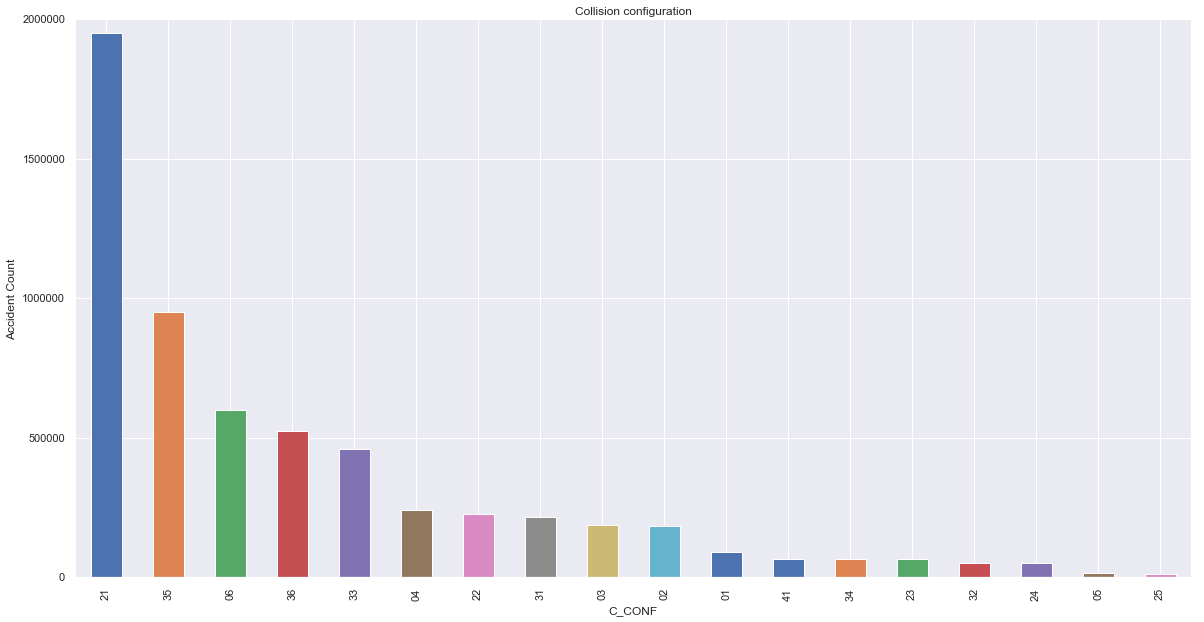

In [49]:
display(by_severity_count(df, 'C_CONF', 'P_ISEV')) 
cleanData(df, 'C_CONF', 'P_ISEV', ['UU', 'QQ'], 1, 42, True)
plotSimpleHist(df['C_CONF'], 'Collision configuration', hight=10, width=20)
display(by_severity_count(df, 'C_CONF', 'P_ISEV'))

#### Clean: C_RCFG

,01,02,03,04,05,06,07,08,09,10,QQ,UU
Severity,,,,,,,,,,,,
non-fatal,840984,1299410,151069,4539,21085,2123,253,5374,774,144,42322,200020
injury,1303027,1508278,152053,14051,29260,3685,611,7159,1141,250,84851,247250
fatal,26279,10823,1172,453,566,75,38,45,6,6,1419,2677


578539 non-numeric rows observed


C:\Users\pradeep\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


0 non-numeric rows observed


,01,02,03,04,05,06,07,08,09,10
Severity,,,,,,,,,,
non-fatal,938295,1426422,164980,5401,23398,2354,290,5936,857,164
injury,1436824,1681899,171145,15183,32389,4034,663,7935,1258,286
fatal,27916,12963,1419,466,610,79,38,56,6,6


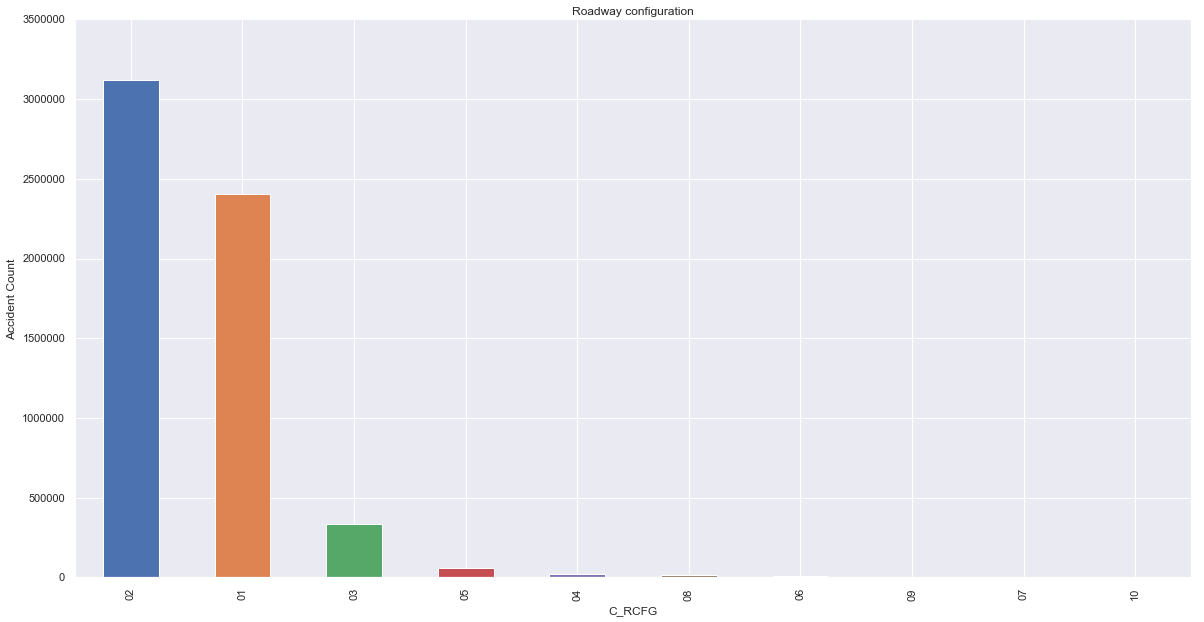

In [50]:
display(by_severity_count(df, 'C_RCFG', 'P_ISEV')) 
cleanData(df, 'C_RCFG', 'P_ISEV', ['UU', 'QQ'], 1, 11, True)
plotSimpleHist(df['C_RCFG'], 'Roadway configuration', hight=10, width=20)
display(by_severity_count(df, 'C_RCFG', 'P_ISEV'))

#### Clean: C_WTHR

,1,2,3,4,5,6,7,Q,U
Severity,,,,,,,,,
non-fatal,1869581,212382,273196,144177,10795,28921,5367,6901,16777
injury,2319449,358552,337813,216649,19966,53397,10325,7638,27827
fatal,29359,5720,3629,2639,299,1231,248,116,318


59577 non-numeric rows observed


C:\Users\pradeep\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


0 non-numeric rows observed


,1,2,3,4,5,6,7
Severity,,,,,,,
non-fatal,1886491,214705,275674,145628,10884,29279,5436
injury,2344929,361983,341392,218815,20165,53926,10406
fatal,29666,5758,3675,2670,302,1240,248


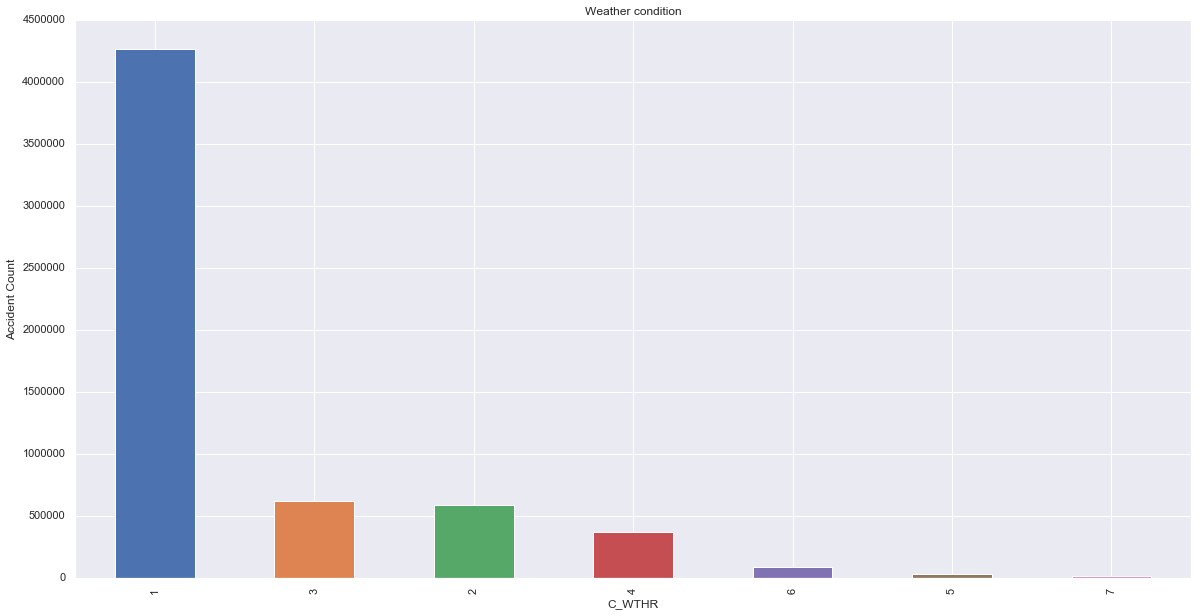

In [51]:
#C_WTHR
display(by_severity_count(df, 'C_WTHR', 'P_ISEV')) 
cleanData(df, 'C_WTHR', 'P_ISEV', ['U', 'Q'], 1, 8, False)
plotSimpleHist(df['C_WTHR'], 'Weather condition', hight=10, width=20)
display(by_severity_count(df, 'C_WTHR', 'P_ISEV'))

#### Clean: Road Surface (C_RSUR)

,1,2,3,4,5,6,7,8,9,Q,U
Severity,,,,,,,,,,,
non-fatal,1748000,486874,92121,29125,110153,5012,1506,316,80,78882,16028
injury,2188576,607841,160043,47371,207226,19851,4155,910,222,93788,21633
fatal,29520,6786,1851,620,2465,534,118,2,8,1385,270


211986 non-numeric rows observed


C:\Users\pradeep\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


0 non-numeric rows observed


,1,2,3,4,5,6,7,8,9
Severity,,,,,,,,,
non-fatal,1813474,505039,96281,30411,115426,5426,1618,338,84
injury,2268004,630120,165108,48879,213693,20393,4256,934,229
fatal,30642,7115,1925,649,2555,545,118,2,8


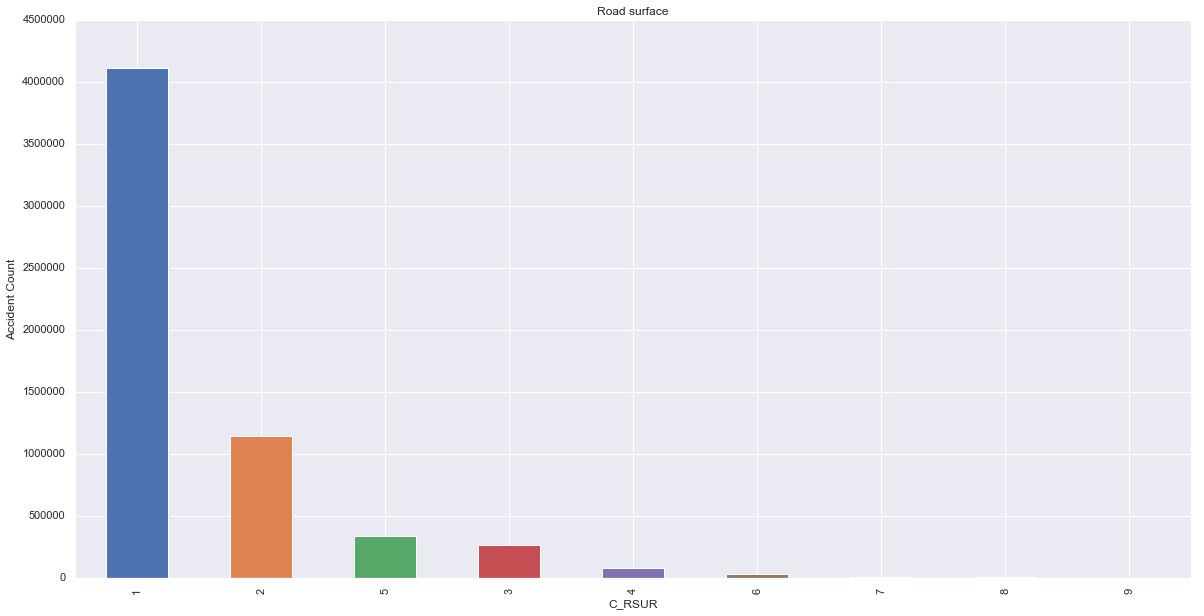

In [52]:
#C_RSUR
display(by_severity_count(df, 'C_RSUR', 'P_ISEV')) 
cleanData(df, 'C_RSUR', 'P_ISEV', ['U', 'Q'], 1, 10, False)
plotSimpleHist(df['C_RSUR'], 'Road surface', hight=10, width=20)
display(by_severity_count(df, 'C_RSUR', 'P_ISEV'))

#### Clean: Road alignment (C_RALN)

,1,2,3,4,5,6,Q,U
Severity,,,,,,,,
non-fatal,1905185,257676,110447,70955,13882,9252,4213,196487
injury,2351221,333729,255850,155488,25777,19353,12209,197989
fatal,24865,5210,6784,4325,557,448,101,1269


412268 non-numeric rows observed


C:\Users\pradeep\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


0 non-numeric rows observed


,1,2,3,4,5,6
Severity,,,,,,
non-fatal,2060149,279044,124045,79268,15299,10292
injury,2513169,356357,270131,164207,27292,20460
fatal,25904,5363,6893,4385,562,452


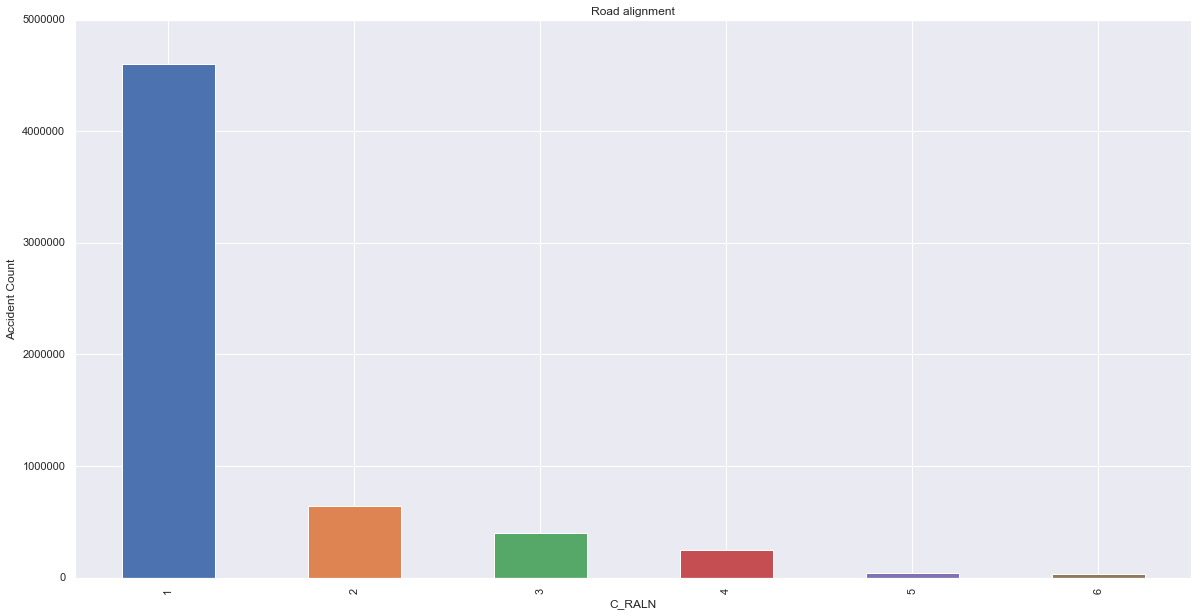

In [53]:
#C_RALN
display(by_severity_count(df, 'C_RALN', 'P_ISEV')) 
cleanData(df, 'C_RALN', 'P_ISEV', ['U', 'Q'], 1, 7, False)
plotSimpleHist(df['C_RALN'], 'Road alignment', hight=10, width=20)
display(by_severity_count(df, 'C_RALN', 'P_ISEV'))

#### Clean: Traffic control (C_TRAF)

,01,02,03,04,05,06,07,08,09,10,11,12,13,15,16,17,18,QQ,UU
Severity,,,,,,,,,,,,,,,,,,,
non-fatal,829897,7956,306313,44242,887,23105,1201,12819,207,682,495,1063,2209,1238,221,1253,1233520,31384,69405
injury,869043,11075,368355,48385,2885,21994,1174,12718,310,1825,2282,1761,2083,2301,629,1831,1847720,39830,115415
fatal,3300,152,3501,221,82,161,10,69,1,65,73,59,11,107,51,32,33646,652,1366


258052 non-numeric rows observed


C:\Users\pradeep\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


0 non-numeric rows observed


,01,02,03,04,05,06,07,08,09,10,11,12,13,15,16,17,18
Severity,,,,,,,,,,,,,,,,,
non-fatal,860005,8270,318317,45874,952,23890,1257,13254,219,719,551,1098,2285,1304,241,1307,1288554
injury,915607,11609,386692,51021,2985,23217,1239,13415,326,1898,2357,1839,2195,2402,664,1907,1932243
fatal,3937,153,3719,250,82,173,12,78,1,66,74,60,12,107,52,32,34751


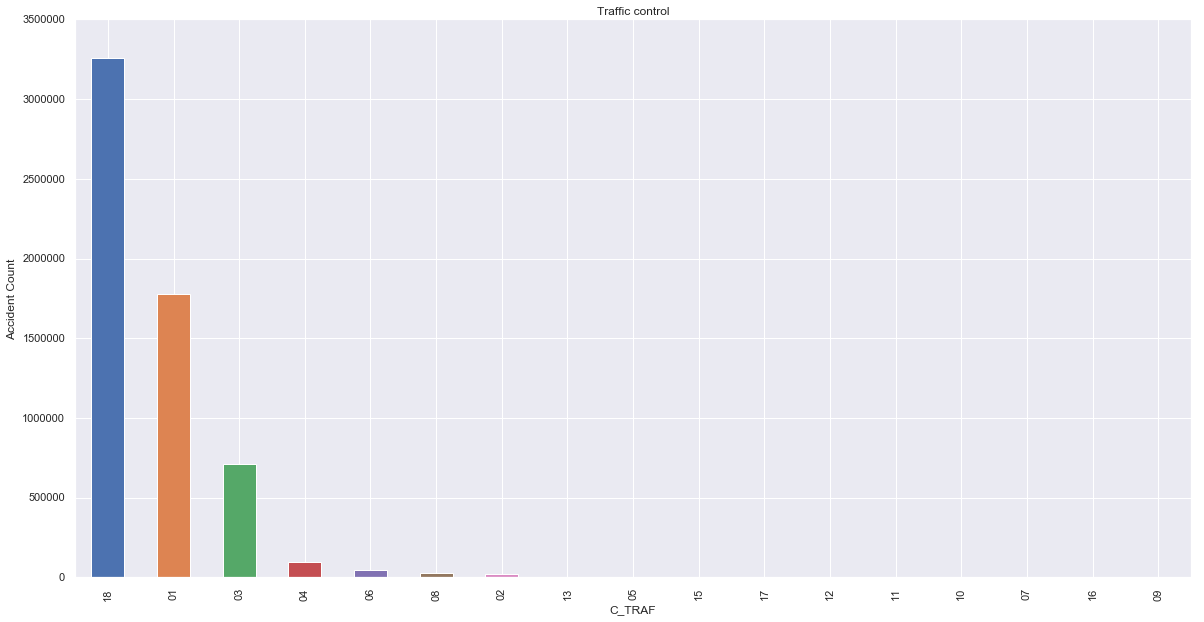

In [54]:
#C_TRAF
display(by_severity_count(df, 'C_TRAF', 'P_ISEV')) 
cleanData(df, 'C_TRAF', 'P_ISEV', ['UU', 'QQ'], 1, 19, True)
plotSimpleHist(df['C_TRAF'], 'Traffic control', hight=10, width=20)
display(by_severity_count(df, 'C_TRAF', 'P_ISEV'))

In [55]:
#### Clean: Vehicle sequence number (V_ID)

,01,02,03,04,05,06,07,08,09,10,...,71,72,73,74,75,76,77,86,99,UU
Severity,,,,,,,,,,,,,,,,,,,,,
non-fatal,1436966.0,877315.0,193394.0,40108.0,8776.0,2726.0,1151.0,632.0,453.0,263.0,...,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,4522.0,19.0
injury,1714280.0,1316105.0,98848.0,15408.0,3065.0,1000.0,475.0,258.0,194.0,104.0,...,1.0,5.0,2.0,0.0,0.0,2.0,1.0,1.0,201011.0,30.0
fatal,28363.0,8842.0,395.0,80.0,36.0,9.0,5.0,3.0,4.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5792.0,2.0


51 non-numeric rows observed


C:\Users\pradeep\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


0 non-numeric rows observed


,01,02,03,04,05,06,07,08,09,10,...,70,71,72,73,74,75,76,77,86,99
Severity,,,,,,,,,,,,,,,,,,,,,
non-fatal,1436974.0,877325.0,193395.0,40108.0,8776.0,2726.0,1151.0,632.0,453.0,263.0,...,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,4522.0
injury,1714298.0,1316111.0,98848.0,15408.0,3065.0,1000.0,475.0,258.0,194.0,104.0,...,0.0,1.0,5.0,2.0,0.0,0.0,2.0,1.0,1.0,201017.0
fatal,28363.0,8843.0,396.0,80.0,36.0,9.0,5.0,3.0,4.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5792.0


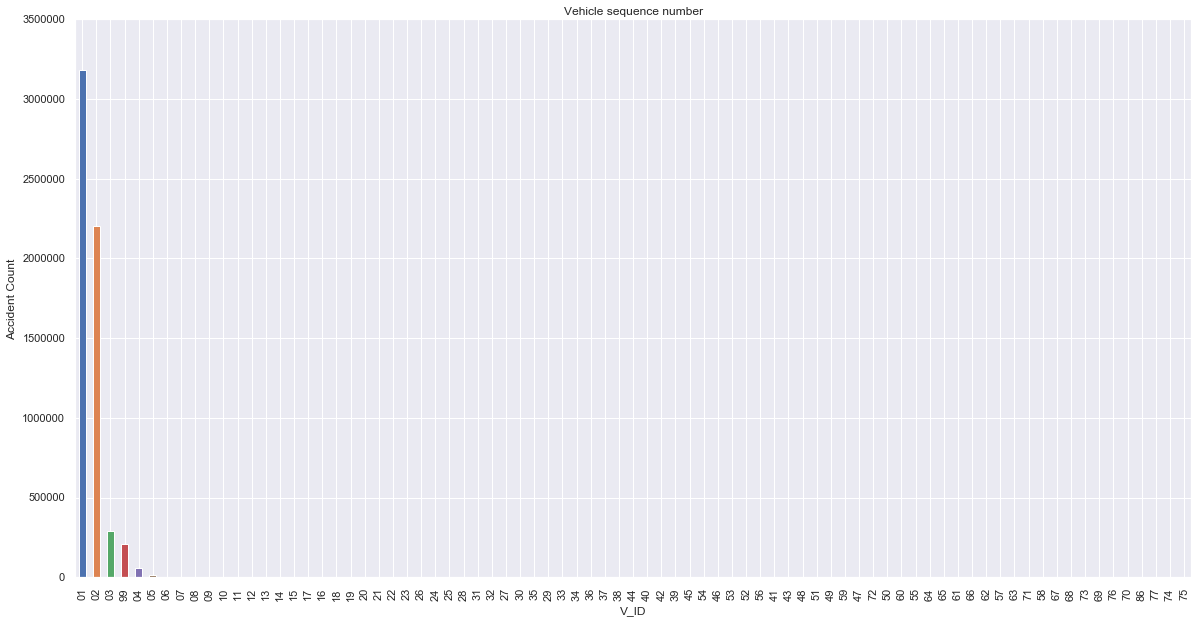

In [56]:
display(by_severity_count(df, 'V_ID', 'P_ISEV')) 
cleanData(df, 'V_ID', 'P_ISEV', ['UU'], 1, 100, True)
plotSimpleHist(df['V_ID'], 'Vehicle sequence number', hight=10, width=20)
display(by_severity_count(df, 'V_ID', 'P_ISEV'))

#### Clean: Vehicle type (V_TYPE)

,01,05,06,07,08,09,10,11,14,16,17,18,19,20,21,22,23,NN,QQ,UU
Severity,,,,,,,,,,,,,,,,,,,,
non-fatal,2239661.0,42135.0,89919.0,54394.0,42318.0,15500.0,628.0,30744.0,11057.0,1441.0,9063.0,1930.0,1349.0,3613.0,685.0,604.0,2453.0,5976.0,8938.0,5689.0
injury,2680170.0,28732.0,86325.0,29163.0,23243.0,6258.0,373.0,20190.0,119620.0,7645.0,122418.0,1262.0,613.0,1938.0,207.0,3236.0,884.0,202147.0,13659.0,3533.0
fatal,29238.0,315.0,1356.0,516.0,741.0,17.0,1.0,83.0,3478.0,441.0,991.0,34.0,44.0,106.0,2.0,240.0,0.0,5801.0,129.0,26.0


245898 non-numeric rows observed


C:\Users\pradeep\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


0 non-numeric rows observed


,01,05,06,07,08,09,10,11,14,16,17,18,19,20,21,22,23
Severity,,,,,,,,,,,,,,,,,
non-fatal,2257531,42401,90553,54698,42554,15589,630,30917,11530,1474,9529,1943,1351,3628,687,617,2465
injury,2870106,31322,93242,32376,25761,7109,410,22208,124749,8023,127412,1401,683,2161,248,3389,1016
fatal,34391,395,1556,584,812,33,1,134,3644,452,1115,38,45,111,3,242,3


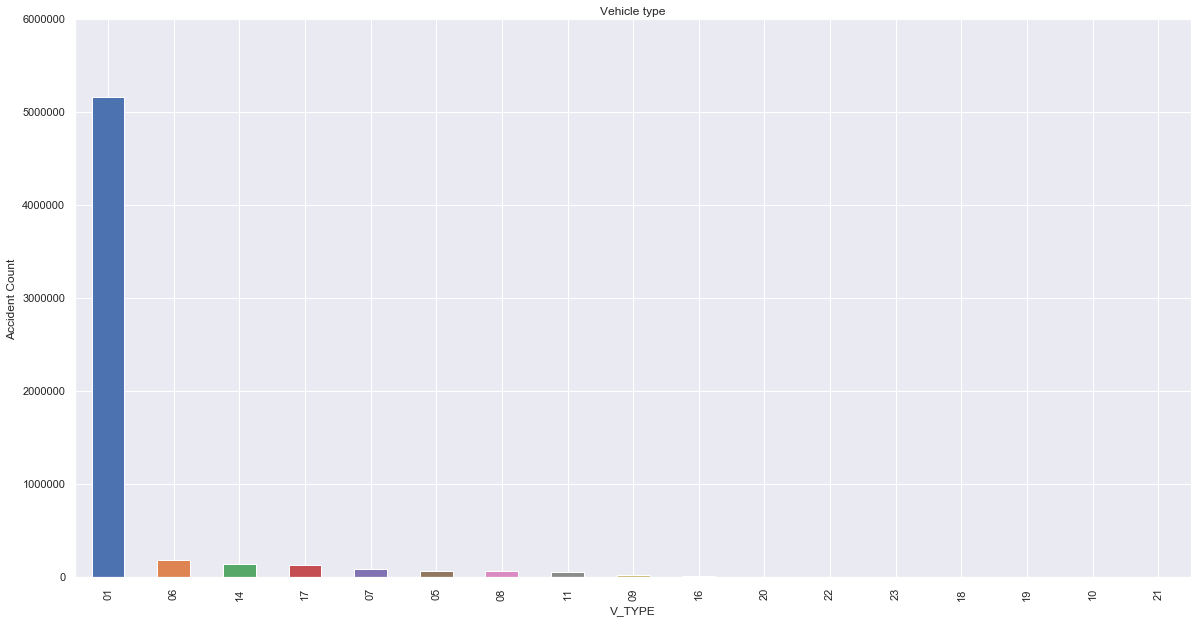

In [57]:
#V_TYPE
display(by_severity_count(df, 'V_TYPE', 'P_ISEV')) 
cleanData(df, 'V_TYPE', 'P_ISEV', ['UU', 'QQ', 'NN'], 1, 24, True)
plotSimpleHist(df['V_TYPE'], 'Vehicle type', hight=10, width=20)
display(by_severity_count(df, 'V_TYPE', 'P_ISEV'))

#### Clean: Vehicle model year ('V_YEAR)

,1901,1903,1904,1905,1906,1907,1908,1909,1910,1911,...,2009,2010,2011,2012,2013,2014,2015,2016,NNNN,UUUU
Severity,,,,,,,,,,,,,,,,,,,,,
non-fatal,8.0,3.0,1.0,0.0,1.0,1.0,2.0,1.0,0.0,8.0,...,58316.0,56569.0,44029.0,38987.0,33243.0,24437.0,17010.0,7406.0,4832.0,111485.0
injury,6.0,5.0,1.0,3.0,0.0,1.0,2.0,0.0,1.0,2.0,...,68804.0,61698.0,44604.0,41274.0,35883.0,26331.0,17284.0,7386.0,242279.0,160160.0
fatal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,585.0,484.0,326.0,330.0,244.0,204.0,135.0,50.0,6120.0,2381.0


C:\Users\pradeep\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\pradeep\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,1901,1903,1904,1905,1906,1907,1908,1909,1910,1911,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
Severity,,,,,,,,,,,,,,,,,,,,,
non-fatal,8.0,3.0,1.0,0.0,1.0,1.0,2.0,1.0,0.0,8.0,...,58316.0,56569.0,44029.0,38987.0,33243.0,24437.0,17010.0,7406.0,4832.0,111485.0
injury,6.0,5.0,1.0,3.0,0.0,1.0,2.0,0.0,1.0,2.0,...,68804.0,61698.0,44604.0,41274.0,35883.0,26331.0,17284.0,7386.0,242279.0,160160.0
fatal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,585.0,484.0,326.0,330.0,244.0,204.0,135.0,50.0,6120.0,2381.0


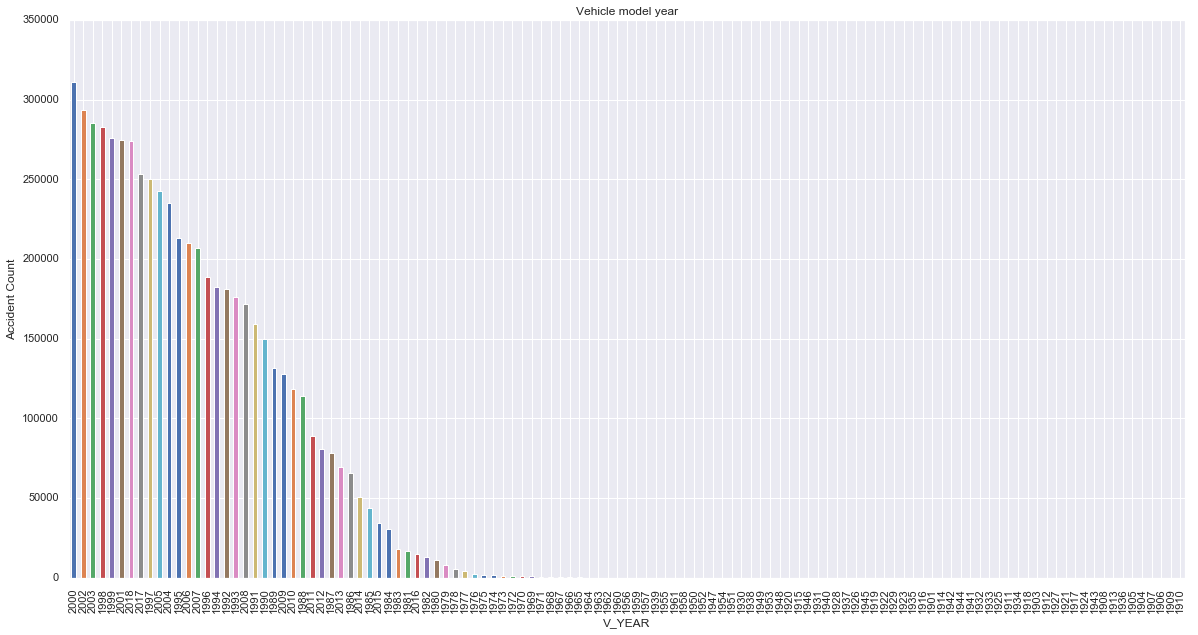

In [58]:
#V_YEAR
display(by_severity_count(df, 'V_YEAR', 'P_ISEV')) 
#cleanData(df, 'V_YEAR', 'P_ISEV', ['UUUU', 'NNNN'], 1, 117, False)

#V_YEAR - Vehicle Year
data_to_impute = df['V_YEAR'].astype('str').str.contains('NNNN')
df['V_YEAR'][data_to_impute] = '2017'

#For now set UUUU to year 2018, unti we find out why the code is not working
data_to_impute = df['V_YEAR'].astype('str').str.contains('UUUU')
df['V_YEAR'][data_to_impute] = '2018'

plotSimpleHist(df['V_YEAR'], 'Vehicle model year', hight=10, width=20)
display(by_severity_count(df, 'V_YEAR', 'P_ISEV'))

#### Clean: Person sequence number (P_ID)

,01,02,03,04,05,06,07,08,09,10,...,87,88,89,90,91,92,93,99,NN,UU
Severity,,,,,,,,,,,,,,,,,,,,,
non-fatal,1778649.0,476140.0,190152.0,78686.0,24826.0,7145.0,3032.0,1434.0,949.0,748.0,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,5.0
injury,2384501.0,713268.0,166270.0,58352.0,17887.0,4938.0,1943.0,876.0,508.0,396.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,14.0
fatal,33104.0,7144.0,2062.0,790.0,301.0,87.0,31.0,12.0,9.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


20 non-numeric rows observed


C:\Users\pradeep\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


1 non-numeric rows observed


,01,02,03,04,05,06,07,08,09,10,...,86,87,88,89,90,91,92,93,99,NN
Severity,,,,,,,,,,,,,,,,,,,,,
non-fatal,1778651.0,476142.0,190153.0,78686.0,24826.0,7145.0,3032.0,1434.0,949.0,748.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
injury,2384510.0,713272.0,166270.0,58352.0,17888.0,4938.0,1943.0,876.0,508.0,396.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
fatal,33104.0,7144.0,2062.0,790.0,301.0,87.0,31.0,12.0,9.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


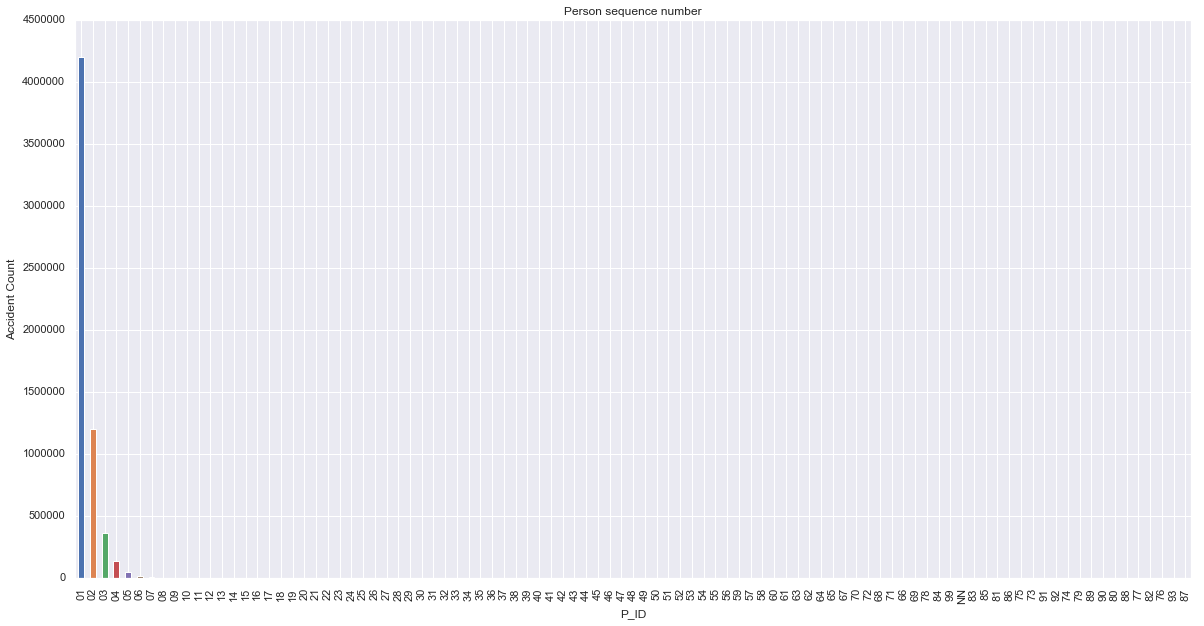

In [59]:
#P_ID
display(by_severity_count(df, 'P_ID', 'P_ISEV')) 
cleanData(df, 'P_ID', 'P_ISEV', ['UU'], 1, 100, True)
plotSimpleHist(df['P_ID'], 'Person sequence number', hight=10, width=20)
display(by_severity_count(df, 'P_ID', 'P_ISEV'))

#### Clean: Person sex (P_SEX)

,F,M,N,U
Severity,,,,
non-fatal,907614.0,1608391.0,209.0,51883.0
injury,1690685.0,1626423.0,27.0,34481.0
fatal,13369.0,30149.0,0.0,41.0


C:\Users\pradeep\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\pradeep\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


86641 non-numeric rows observed


C:\Users\pradeep\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


0 non-numeric rows observed


,0,1,2
Severity,,,
non-fatal,907614,1631573,28910
injury,1690685,1641671,19260
fatal,13369,30167,23


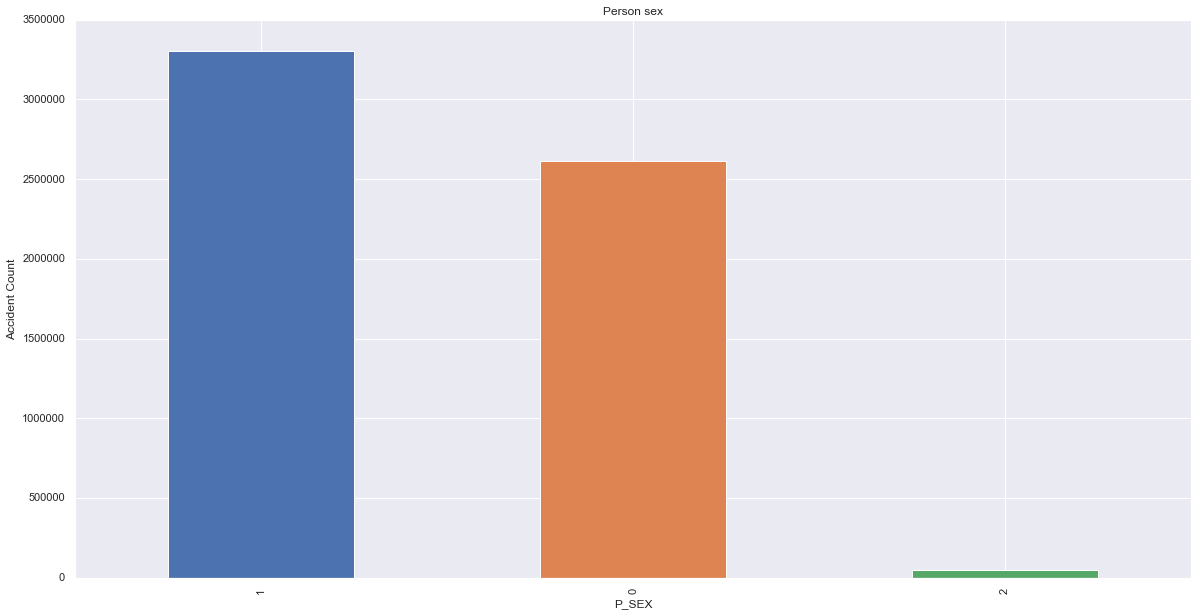

In [60]:
#P_SEX
display(by_severity_count(df, 'P_SEX', 'P_ISEV')) 

data_to_impute = df['P_SEX'].astype('str').str.contains('F')
df['P_SEX'][data_to_impute] = '0'
data_to_impute = df['P_SEX'].astype('str').str.contains('M')
df['P_SEX'][data_to_impute] = '1'

cleanData(df, 'P_SEX', 'P_ISEV', ['U', 'N'], 1,3, False)
plotSimpleHist(df['P_SEX'], 'Person sex', hight=10, width=20)
display(by_severity_count(df, 'P_SEX', 'P_ISEV'))

#### Clean: Person age (P_AGE)

,01,02,03,04,05,06,07,08,09,10,...,92,93,94,95,96,97,98,99,NN,UU
Severity,,,,,,,,,,,,,,,,,,,,,
non-fatal,30821,19312,18478,18001,17208,15524,15194,14915,14483,14697,...,410,256,167,113,60,40,74,144,200,146748
injury,13175,8260,9303,10722,11668,12667,13768,14381,15052,16070,...,708,516,357,207,143,95,149,171,2423,98968
fatal,149,72,67,97,98,98,104,90,108,110,...,51,39,25,20,13,7,6,8,5,211


248555 non-numeric rows observed


C:\Users\pradeep\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


0 non-numeric rows observed


,01,02,03,04,05,06,07,08,09,10,...,90,91,92,93,94,95,96,97,98,99
Severity,,,,,,,,,,,,,,,,,,,,,
non-fatal,31941,20053,19174,18766,17948,16265,15889,15725,15254,15520,...,948,610,445,274,178,122,68,44,77,148
injury,13949,8729,9792,11227,12173,13183,14269,14921,15609,16581,...,1546,1019,728,523,370,216,145,98,155,176
fatal,150,75,68,98,99,99,104,90,108,111,...,82,82,51,39,25,20,13,7,6,8


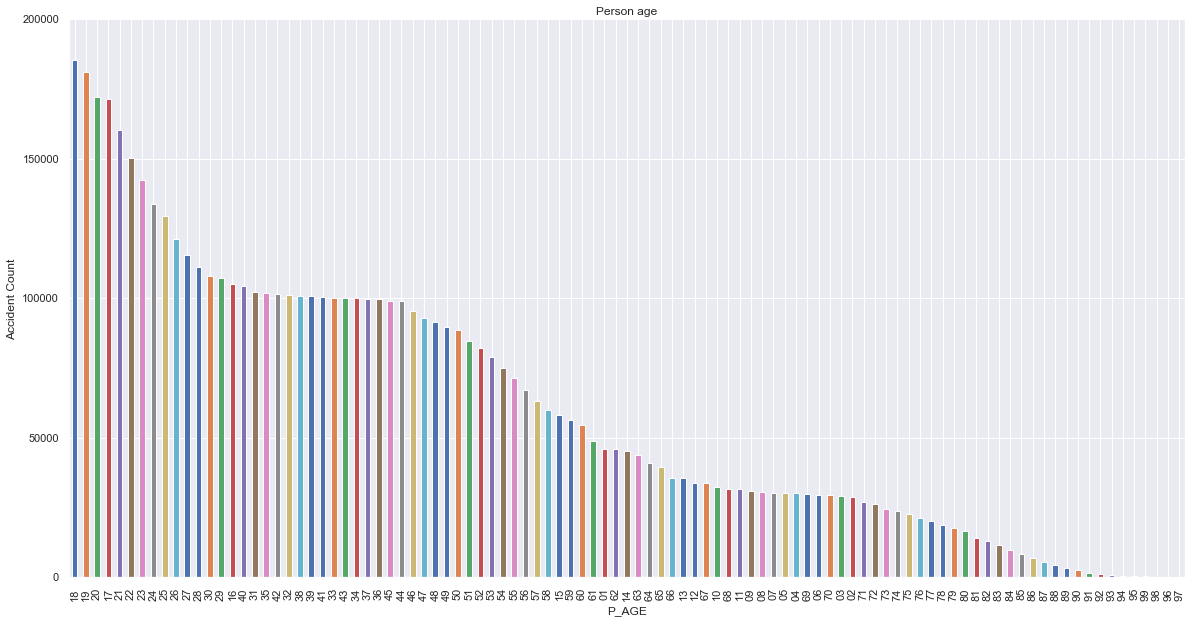

In [61]:
#P_AGE
display(by_severity_count(df, 'P_AGE', 'P_ISEV')) 
cleanData(df, 'P_AGE', 'P_ISEV', ['UU', 'NN'], 1, 100, True)
plotSimpleHist(df['P_AGE'], 'Person age', hight=10, width=20)
display(by_severity_count(df, 'P_AGE', 'P_ISEV'))

#### Clean: Person position

,11,12,13,21,22,23,31,32,33,96,97,98,99,NN,QQ,UU
Severity,,,,,,,,,,,,,,,,
non-fatal,1782609,33153,379561,123811,52415,149840,2931,17486,3574,11577,117,1072,4256,45,2122,3528
injury,2165018,59148,572621,110616,43469,130551,2098,14533,2815,34133,158,5514,200994,142,2932,6874
fatal,26626,592,5846,1337,489,1288,35,216,36,997,4,111,5792,3,53,134


15833 non-numeric rows observed


C:\Users\pradeep\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


0 non-numeric rows observed


,11,12,13,21,22,23,31,32,33,96,97,98,99
Severity,,,,,,,,,,,,,
non-fatal,1786417,33217,380516,124014,52497,150120,2935,17514,3582,11619,117,1078,4471
injury,2171690,59297,574186,111038,43626,130999,2107,14588,2823,34221,159,5522,201360
fatal,26758,595,5874,1343,492,1296,35,216,36,999,4,111,5800


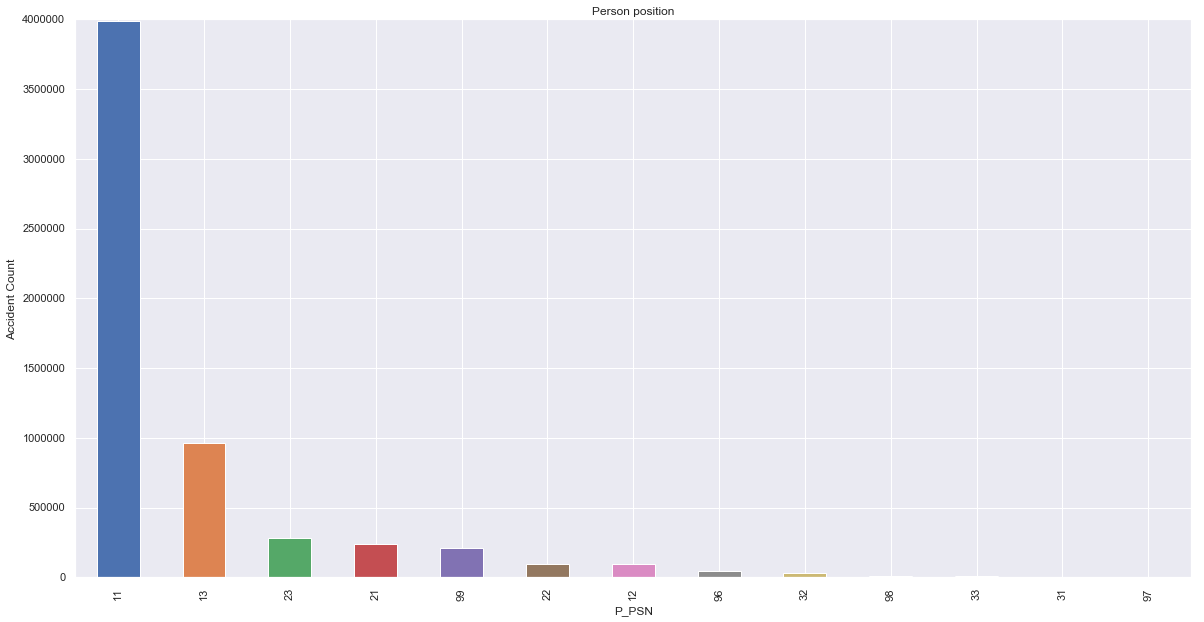

In [62]:
#P_PSN
display(by_severity_count(df, 'P_PSN', 'P_ISEV')) 
cleanData(df, 'P_PSN', 'P_ISEV', ['UU','NN', 'QQ'], 1, 100, True)
plotSimpleHist(df['P_PSN'], 'Person position', hight=10, width=20)
display(by_severity_count(df, 'P_PSN', 'P_ISEV'))

#### Clean: Safety device used

,01,02,09,10,11,12,13,NN,QQ,UU
Severity,,,,,,,,,,
non-fatal,32656,2007645,3621,8,3,5001,32197,171569,11327,304070
injury,165288,2548978,105590,143,9,20746,120726,141379,39976,208781
fatal,11044,18070,2938,11,1,348,2278,3378,715,4776


885971 non-numeric rows observed


C:\Users\pradeep\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


0 non-numeric rows observed


,01,02,09,10,11,12,13
Severity,,,,,,,
non-fatal,52671,2446452,14392,16,4,7443,47119
injury,181217,2900596,114297,159,11,22729,132607
fatal,11388,26082,3123,11,1,396,2558


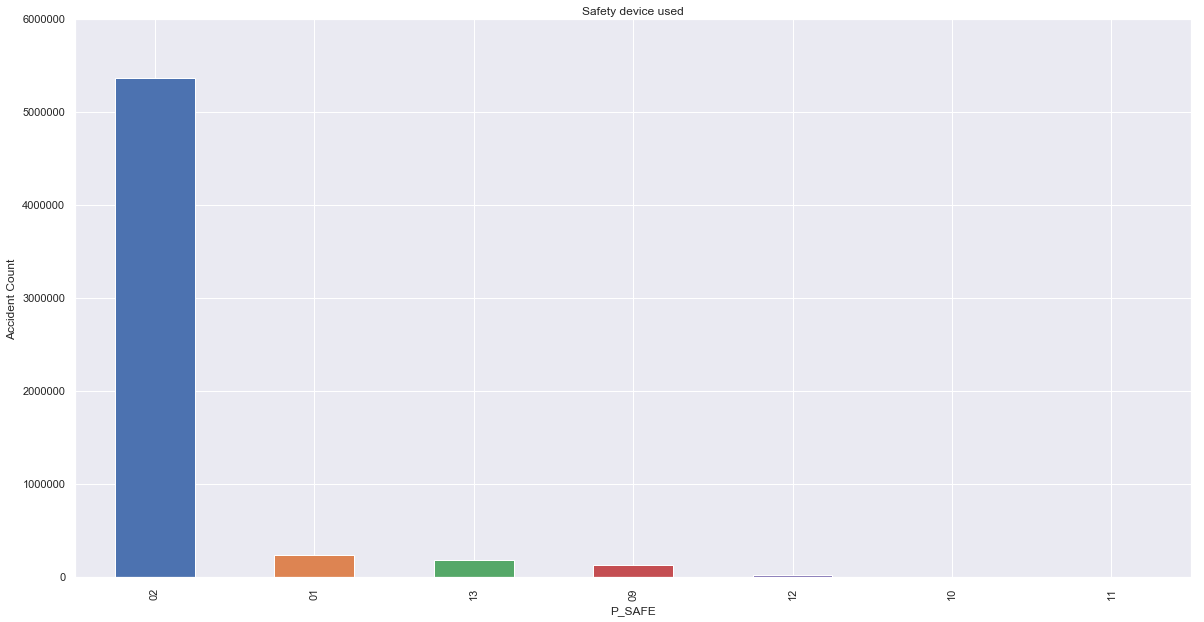

In [63]:
#P_SAFE
display(by_severity_count(df, 'P_SAFE', 'P_ISEV')) 
cleanData(df, 'P_SAFE', 'P_ISEV', ['UU','NN', 'QQ'], 1, 14, True)
plotSimpleHist(df['P_SAFE'], 'Safety device used', hight=10, width=20)
display(by_severity_count(df, 'P_SAFE', 'P_ISEV'))

#### Clean: Road user class

In [ ]:
#P_USER
display(by_severity_count(df, 'P_USER', 'P_ISEV')) 
cleanData(df, 'P_USER', 'P_ISEV', ['U'], 1, 6, False)
plotSimpleHist(df['P_USER'], 'Road user class', hight=10, width=20)
display(by_severity_count(df, 'P_USER', 'P_ISEV'))

,1,2,3,4,5,U
Severity,,,,,,
non-fatal,1748373,765779,4522,9063,11057,29303
injury,1945995,918288,201011,122418,119620,44284
fatal,22283,9764,5792,991,3478,1251


74838 non-numeric rows observed


#### Check that we have no non numeric values

In [ ]:
print("This dataset has {0} missing value".format(df.isnull().sum().sum()))
print("This dataset has {0} NA value".format(df.isna().sum().sum()))
print("This dataset has {0} non numeric value".format(df[df.index.astype('str').str.contains('[^0-9]')].sum().sum()))

### Write Dataset to clean 

In [ ]:
df.to_csv('data01_clean.csv', encoding='utf-8', index=False)

In [ ]:
print(df.shape)

In [ ]:
#### Clean Accident month column
#import random


#Collisions by Month
#print("{count} non-numeric rows observed".format(count = df['C_MNTH'].astype('str').str.contains('[^0-9]').sum()))
#by_month = df.groupby(['C_MNTH','P_ISEV']).size()
#plt_enabled = False
#if (plt_enabled):
#    plot = by_month.plot(figsize=(20,15), kind='bar',title='Collisions by Year');
#
#tmp = df.index[df['C_MNTH'].astype('str').str.contains('[^0-9]')]
    
## Not much variations accross the months, we are going to randomly (with equal probability)
#months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

#df['C_MNTH'] = df['C_MNTH'].apply(lambda x: x.replace('UU', np.random.choice(months)))

#print("{count} non-numeric rows observed".format(count = df['C_MNTH'].astype('str').str.contains('[^0-9]').sum()))



In [ ]:
#### Clean Accident Hour column

#Collisions by weekday
#print("{count} non-numeric rows observed".format(count = df['C_HOUR'].astype('str').str.contains('[^0-9]').sum()))
#by_weekday = df.groupby(['C_HOUR','P_ISEV']).size().unstack()
#plt_enabled = False
#if (plt_enabled):
#    plot = by_weekday.plot(figsize=(20,15), kind='bar',title='Collisions by HOUR', stacked = False);

#To many levels, lets reduce the number of levels by combining the hours
#[8pm-6am], [7am-7pm]
#night = ['22', '23', '00', '01', '02', '03', '04', '05']
#morning = ['06', '07', '08', '09', '10', '11']
#activeHours = ['12', '13', '14', '15', '16', '17', '18', '19', '20', '21'] 

#df['C_HOUR'] = df['C_HOUR'].apply(lambda x: x.replace(Night, '1'))
#df['C_HOUR'] = df['C_HOUR'].apply(lambda x: x.replace(Night, '1'))
#df['C_HOUR'] = df['C_HOUR'].apply(lambda x: '1' if x in night else '2' if x in morning else '3')
#print("{count} non-numeric rows observed".format(count = df['C_HOUR'].astype('str').str.contains('[^0-9]').sum()))

#if (plt_enabled):
#    plot = by_weekday.plot(figsize=(20,15), kind='bar',title='Collisions by HOUR', stacked = False);


In [ ]:
#set the correct type for each variable
#df = df.astype('category')
#df['C_YEAR'] = df['C_YEAR'].astype('int64')
#df['C_VEHS'] = df['C_VEHS'].astype('int64')
#df['V_YEAR'] = df['V_YEAR'].astype('int64')
#df['P_AGE'] = df['P_AGE'].astype('int64')

In [ ]:
#df of categorical and numberic varaibales
#df_cat = df.select_dtypes(include=['category']).copy()
#df_int = df.select_dtypes(include=['int64']).copy()

In [ ]:
#print(df_cat.head())
#print(df_int.head())

In [ ]:
#pd.options.display.float_format = '{:.4g}'.format
#df_int.describe()

In [ ]:
#df_int[['C_VEHS']].boxplot()

In [ ]:
#df_int[['P_AGE']].boxplot()

In [ ]:
if debug:
    #The overall diagram
    plot1 = df1.plot(figsize=(10,10),title='Collision overall statistics')
    plot1.set_xlabel("Year")
    plot1.set_ylabel("Number of collisions");

In [ ]:
if debug:
    #Collisions by weekday
    by_weekday = df_b.groupby('C_WDAY')['P_ISEV'].count()
    by_weekday.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    plot2 = by_weekday.plot(kind='bar',title='Collisions by day');

In [ ]:
if debug:
    #Collisions by hour
    plt.figure(figsize=(15,5))
    by_hour = df_b.groupby('C_HOUR')['P_ISEV'].count()
    plot3 = by_hour.plot(kind='bar',title='Collisions by hour',color='B');

In [ ]:
if debug:
    #Year vs Severity
    df.groupby(['C_YEAR', 'P_ISEV']).size().unstack().plot(figsize=(10,10), kind='bar', title = 'Year vs Accident Severity', stacked = True)

In [ ]:
if debug:
    #Year vs Severity
    df.groupby(['C_MNTH', 'P_ISEV']).size().unstack().plot(figsize=(10,10), kind='bar', title = 'Month vs Accident Severity', stacked = True)

In [ ]:
if debug:
    #Year vs Severity
    df.groupby(['C_WDAY', 'P_ISEV']).size().unstack().plot(figsize=(10,10), kind='bar', title = 'Day vs Accident Severity', stacked = True)

In [ ]:
if debug:
    #Year vs Severity
    df.groupby(['C_HOUR', 'P_ISEV']).size().unstack().plot(figsize=(10,10), kind='bar', title = 'HOUR vs Accident Severity', stacked = True)

In [ ]:
if debug:
    #Year vs Severity
    df.groupby(['C_VEHS', 'P_ISEV']).size().unstack().plot(figsize=(10,10), kind='bar', title = 'C_VEHS vs Accident Severity', stacked = True)

In [ ]:
if debug:
    #Year vs Severity
    df.groupby(['C_CONF', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'C_CONF vs Accident Severity', stacked = True)

In [ ]:
if debug:
    #Year vs Severity
    df.groupby(['C_RCFG', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'C_RCFG vs Accident Severity', stacked = True)

In [ ]:
if debug:
    #Year vs Severity
    df.groupby(['C_WTHR', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'C_WTHR vs Accident Severity', stacked = True)

In [ ]:
if debug:
    #Year vs Severity
    df.groupby(['C_RSUR', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'C_WTHR vs Accident Severity', stacked = True)

In [ ]:
if debug:
    #Year vs Severity
    df.groupby(['C_RALN', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'C_RALN vs Accident Severity', stacked = True)

In [ ]:
if debug:
    #Year vs Severity
    df.groupby(['C_TRAF', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'C_TRAF vs Accident Severity', stacked = True)

In [ ]:
if debug:
    #Year vs Severity
    df.groupby(['V_ID', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'V_ID vs Accident Severity', stacked = True)

In [ ]:
if debug:
    #Year vs Severity
    df.groupby(['V_TYPE', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'V_TYPE vs Accident Severity', stacked = True)

In [ ]:
if debug:
    #Year vs Severity
    df.groupby(['V_YEAR', 'P_ISEV']).size().unstack().plot(figsize=(25,20), kind='bar', title = 'V_YEAR vs Accident Severity', stacked = True)

In [ ]:
if debug:
    #Year vs Severity
    df.groupby(['P_ID', 'P_ISEV']).size().unstack().plot(figsize=(25,20), kind='bar', title = 'P_ID vs Accident Severity', stacked = True)

In [ ]:
if debug:
    #Year vs Severity
    df.groupby(['P_SEX', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'P_SEX vs Accident Severity', stacked = True)

In [ ]:
if debug:
    #Year vs Severity
    df.groupby(['P_AGE', 'P_ISEV']).size().unstack().plot(figsize=(25,20), kind='bar', title = 'P_AGE vs Accident Severity', stacked = True)

In [ ]:
if debug:
    #Year vs Severity
    df.groupby(['P_PSN', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'P_PSN vs Accident Severity', stacked = True)

In [ ]:
if debug:
    #Year vs Severity
    df.groupby(['P_SAFE', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'P_SAFE vs Accident Severity', stacked = True)

In [ ]:
if debug:
    #Year vs Severity
    df.groupby(['P_USER', 'P_ISEV']).size().unstack().plot(figsize=(10,15), kind='bar', title = 'P_USER vs Accident Severity', stacked = True)

In [ ]:
if debug:
    #Year vs Severity
    df.groupby(['P_ISEV', 'P_ISEV']).size().unstack().plot(figsize=(8,10), kind='bar', title = 'P_ISEV vs Accident Severity', stacked = True)

In [ ]:
#%matplotlib inline
#df_int[['C_VEHS', 'P_AGE']].boxplot()

In [ ]:
#check if dataset contains nulls
if df.isnull().sum().sum():
    print("Dataset contains Null values")
else:
    print("No Null values in the Dataset")

In [ ]:
if df.isna().sum().sum():
    print("Dataset contains missing values")
else:
    print("No missing values in the Dataset")